# Analytics

#### Date: 2021/01

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM: SysArq

##### Semester: 2021/01
##### Professor: Hilmer Neri

##### Members:

- 
- Member y

### LIBRARIES

In [110]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Datetime
from datetime import datetime

### GRAPH SETTINGS

In [4]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [5]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [6]:
jsons = glob('../analytics-raw-data/*.json') # add the path here

In [9]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"PC-GO1-(.*?)-*-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [10]:
base_component_df = create_base_component_df(jsons)

In [33]:
base_component_df.head(10)

,bestValue,metric,value,filename,repository,version
9,True,duplicated_lines_density,0.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
10,NaN,functions,41,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
11,True,security_rating,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
12,NaN,files,16,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
13,NaN,complexity,42,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
14,NaN,ncloc,878,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
15,False,coverage,97.3,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
16,True,reliability_rating,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
17,False,comment_lines_density,7.7,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
45,True,duplicated_lines_density,0.0,fga-eps-mds-2021_1-PC-GO1-Archives-13-09-2021-...,Archives,13-09-2021-15-00


#### Create dataframe per file

In [12]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [69]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns, dtype=object)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)
        
        file_component_df_py = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'py')
        file_component_df_js = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')

        file_component_df_py['filename'] = os.path.basename(i)
        file_component_df_js['filename'] = os.path.basename(i)

        df = df.append(file_component_df_js, ignore_index=True)
        df = df.append(file_component_df_py, ignore_index=True)
          
    aux_df = df['filename'].str.split(r"PC-GO1-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [70]:
file_component_df = create_file_df(jsons)

In [71]:
len(file_component_df)

108

In [72]:
# file_component_df.to_excel('data/data.xlsx', index = False)

#### Create dataframe per repository

In [73]:
archives_df = file_component_df[file_component_df['repository'] == 'Archives']
profile_df = file_component_df[file_component_df['repository'] == 'Profile']
frontend_df = file_component_df[file_component_df['repository'] == 'Frontend']

### Metric calculations

##### COMPLEXITY

In [74]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [75]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [76]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

### Calculate m1, m2 and m3 for each repository

In [77]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'repository': repository_list, 
                               'version': version_list})
        
    return metrics_df

In [78]:
archives_metrics = create_metrics_df(archives_df)
profile_metrics = create_metrics_df(profile_df)
frontend_metrics = create_metrics_df(frontend_df)

### Data visualization

- You must do this for each of your repositories

# M1

## Archives

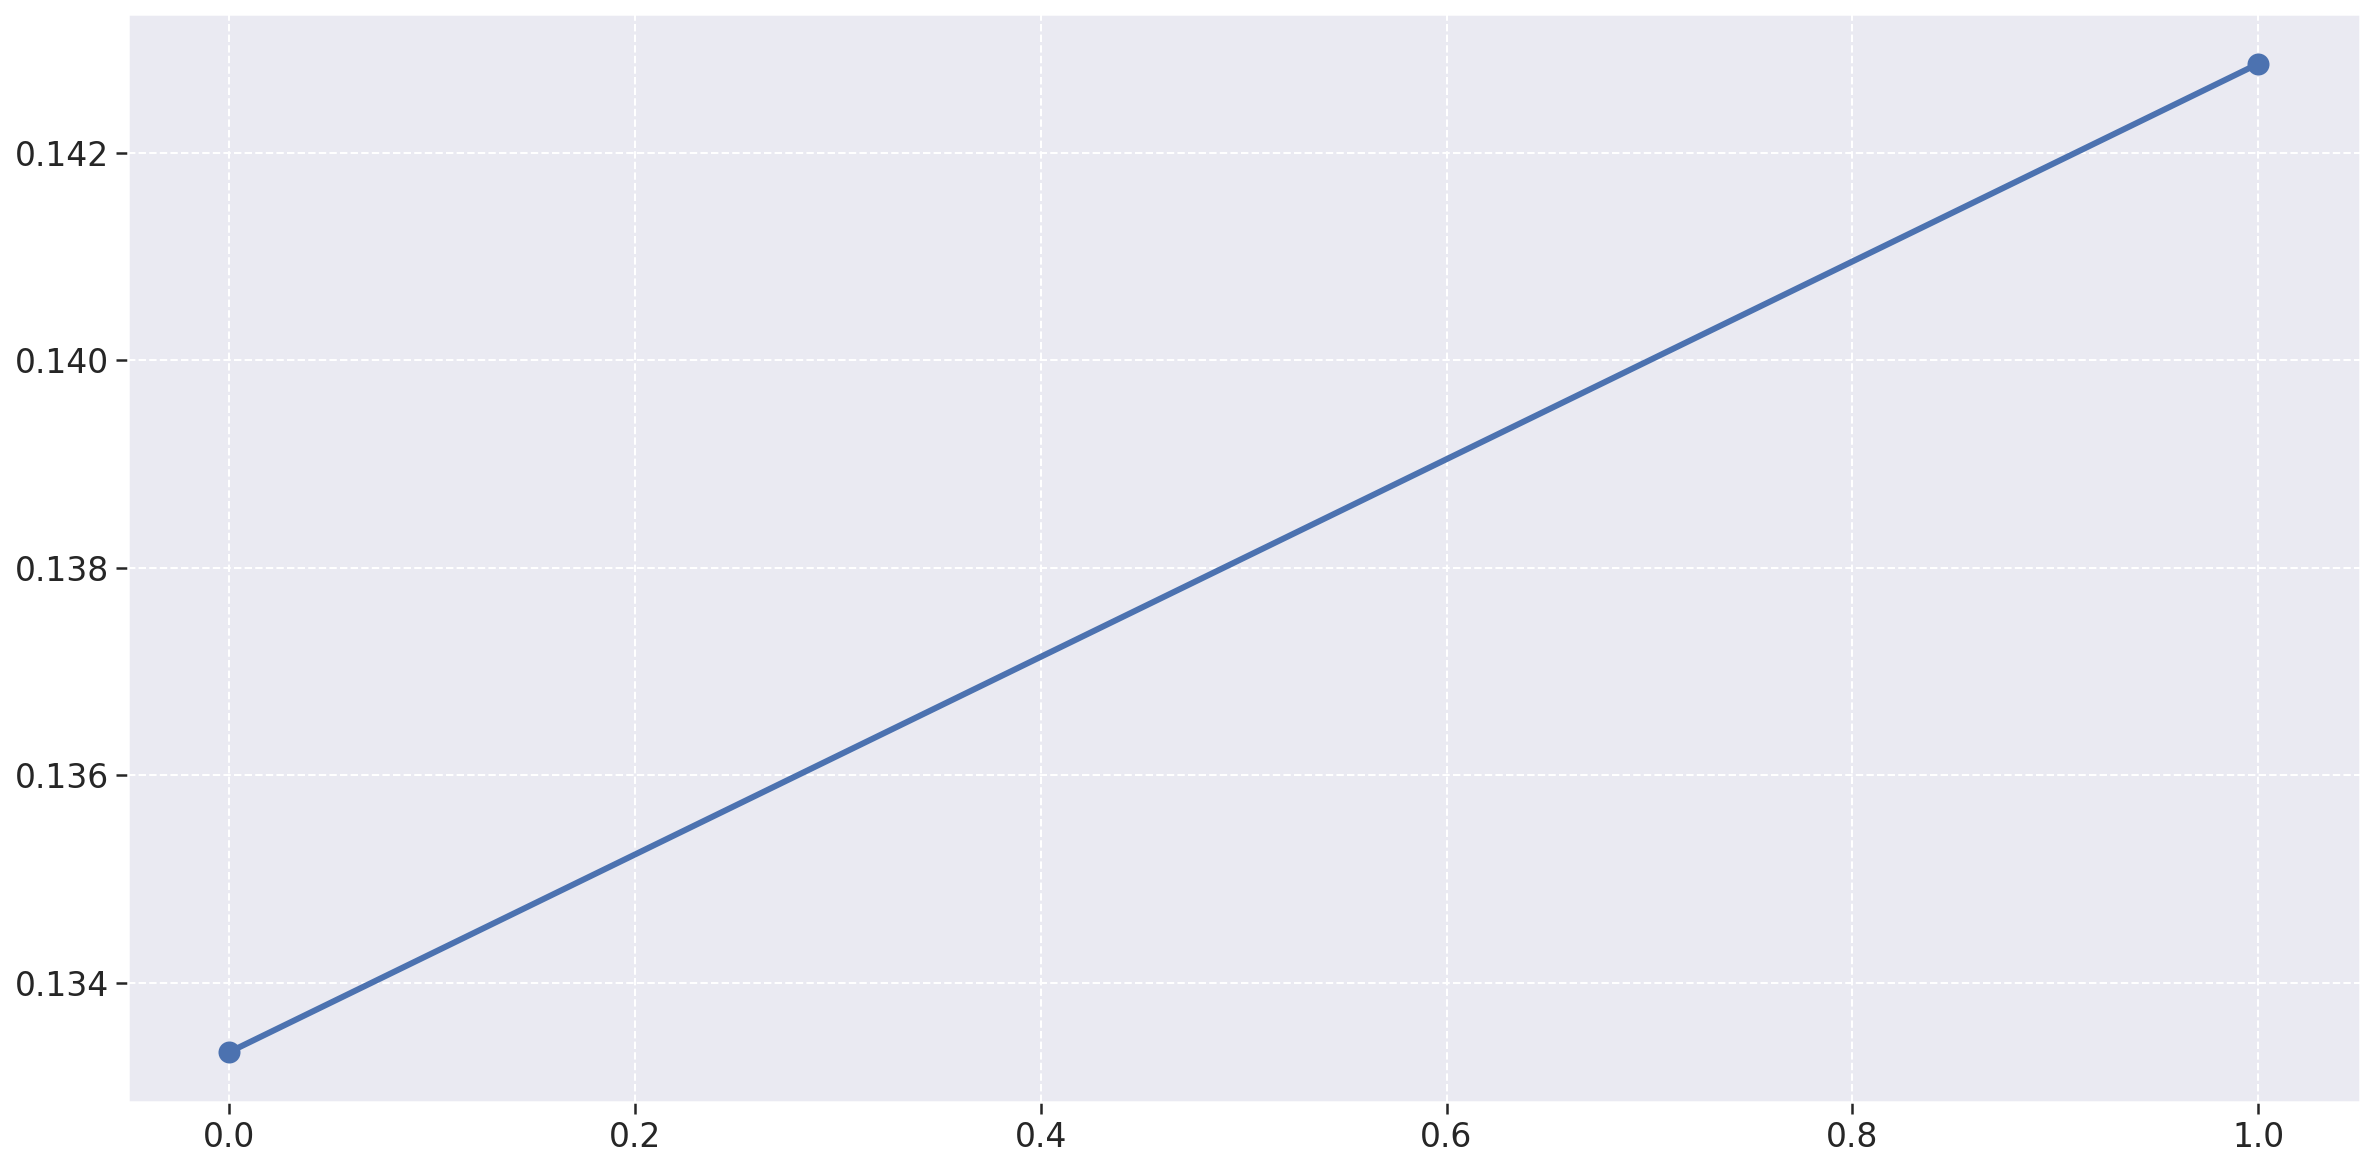

In [79]:
fig = plt.figure(figsize=(20, 10))

plt.plot(archives_metrics['m1'], linewidth=3, marker='o', markersize=10)

## Profile

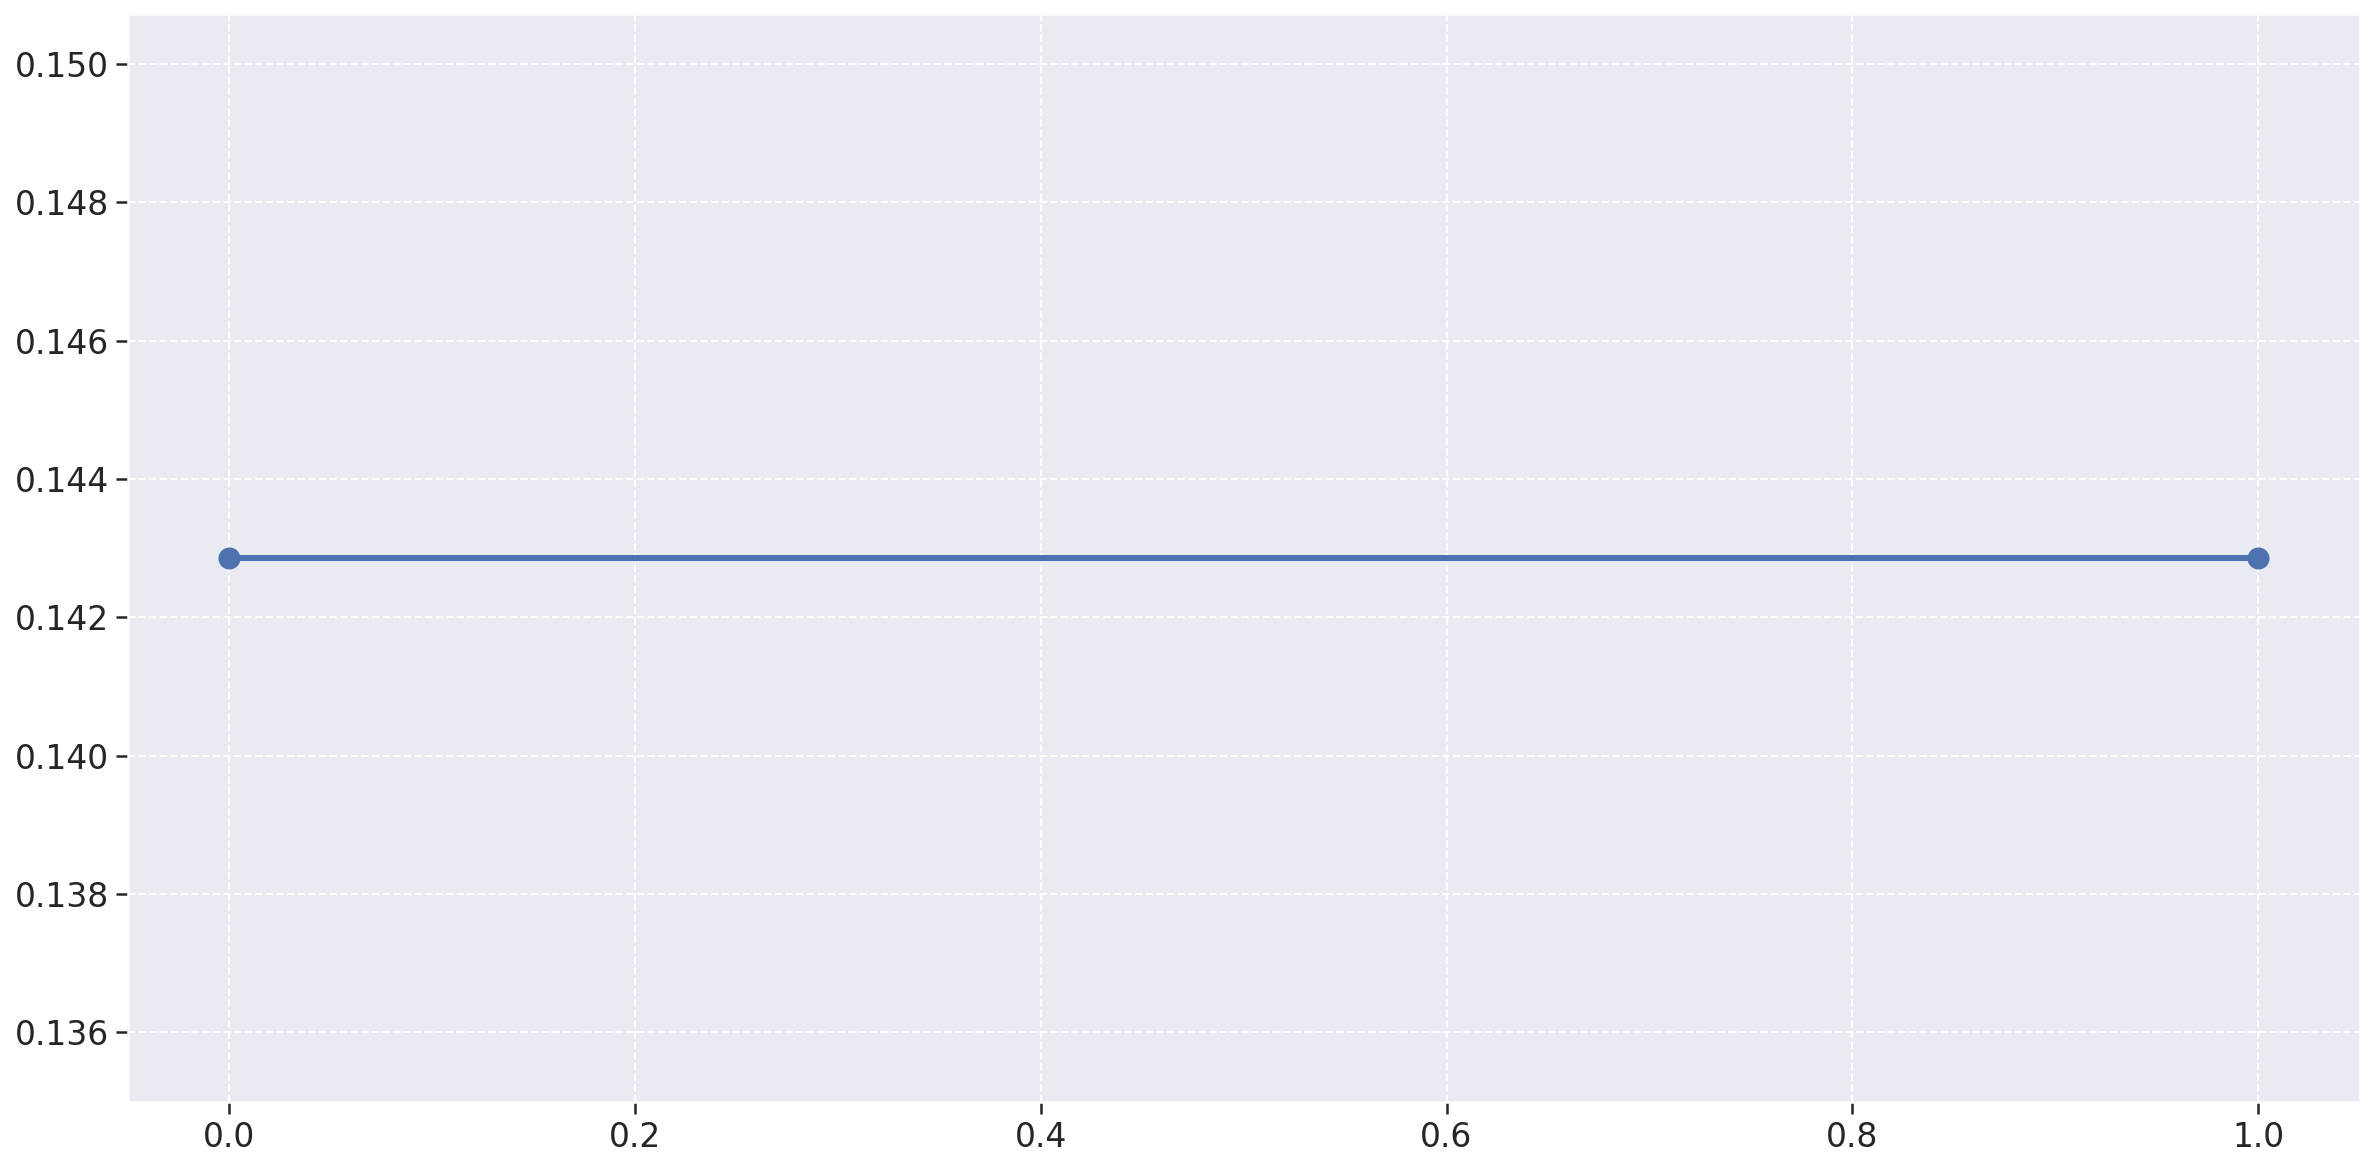

In [92]:
fig = plt.figure(figsize=(20, 10))

plt.plot(profile_metrics['m1'], linewidth=3, marker='o', markersize=10)

## Frontend

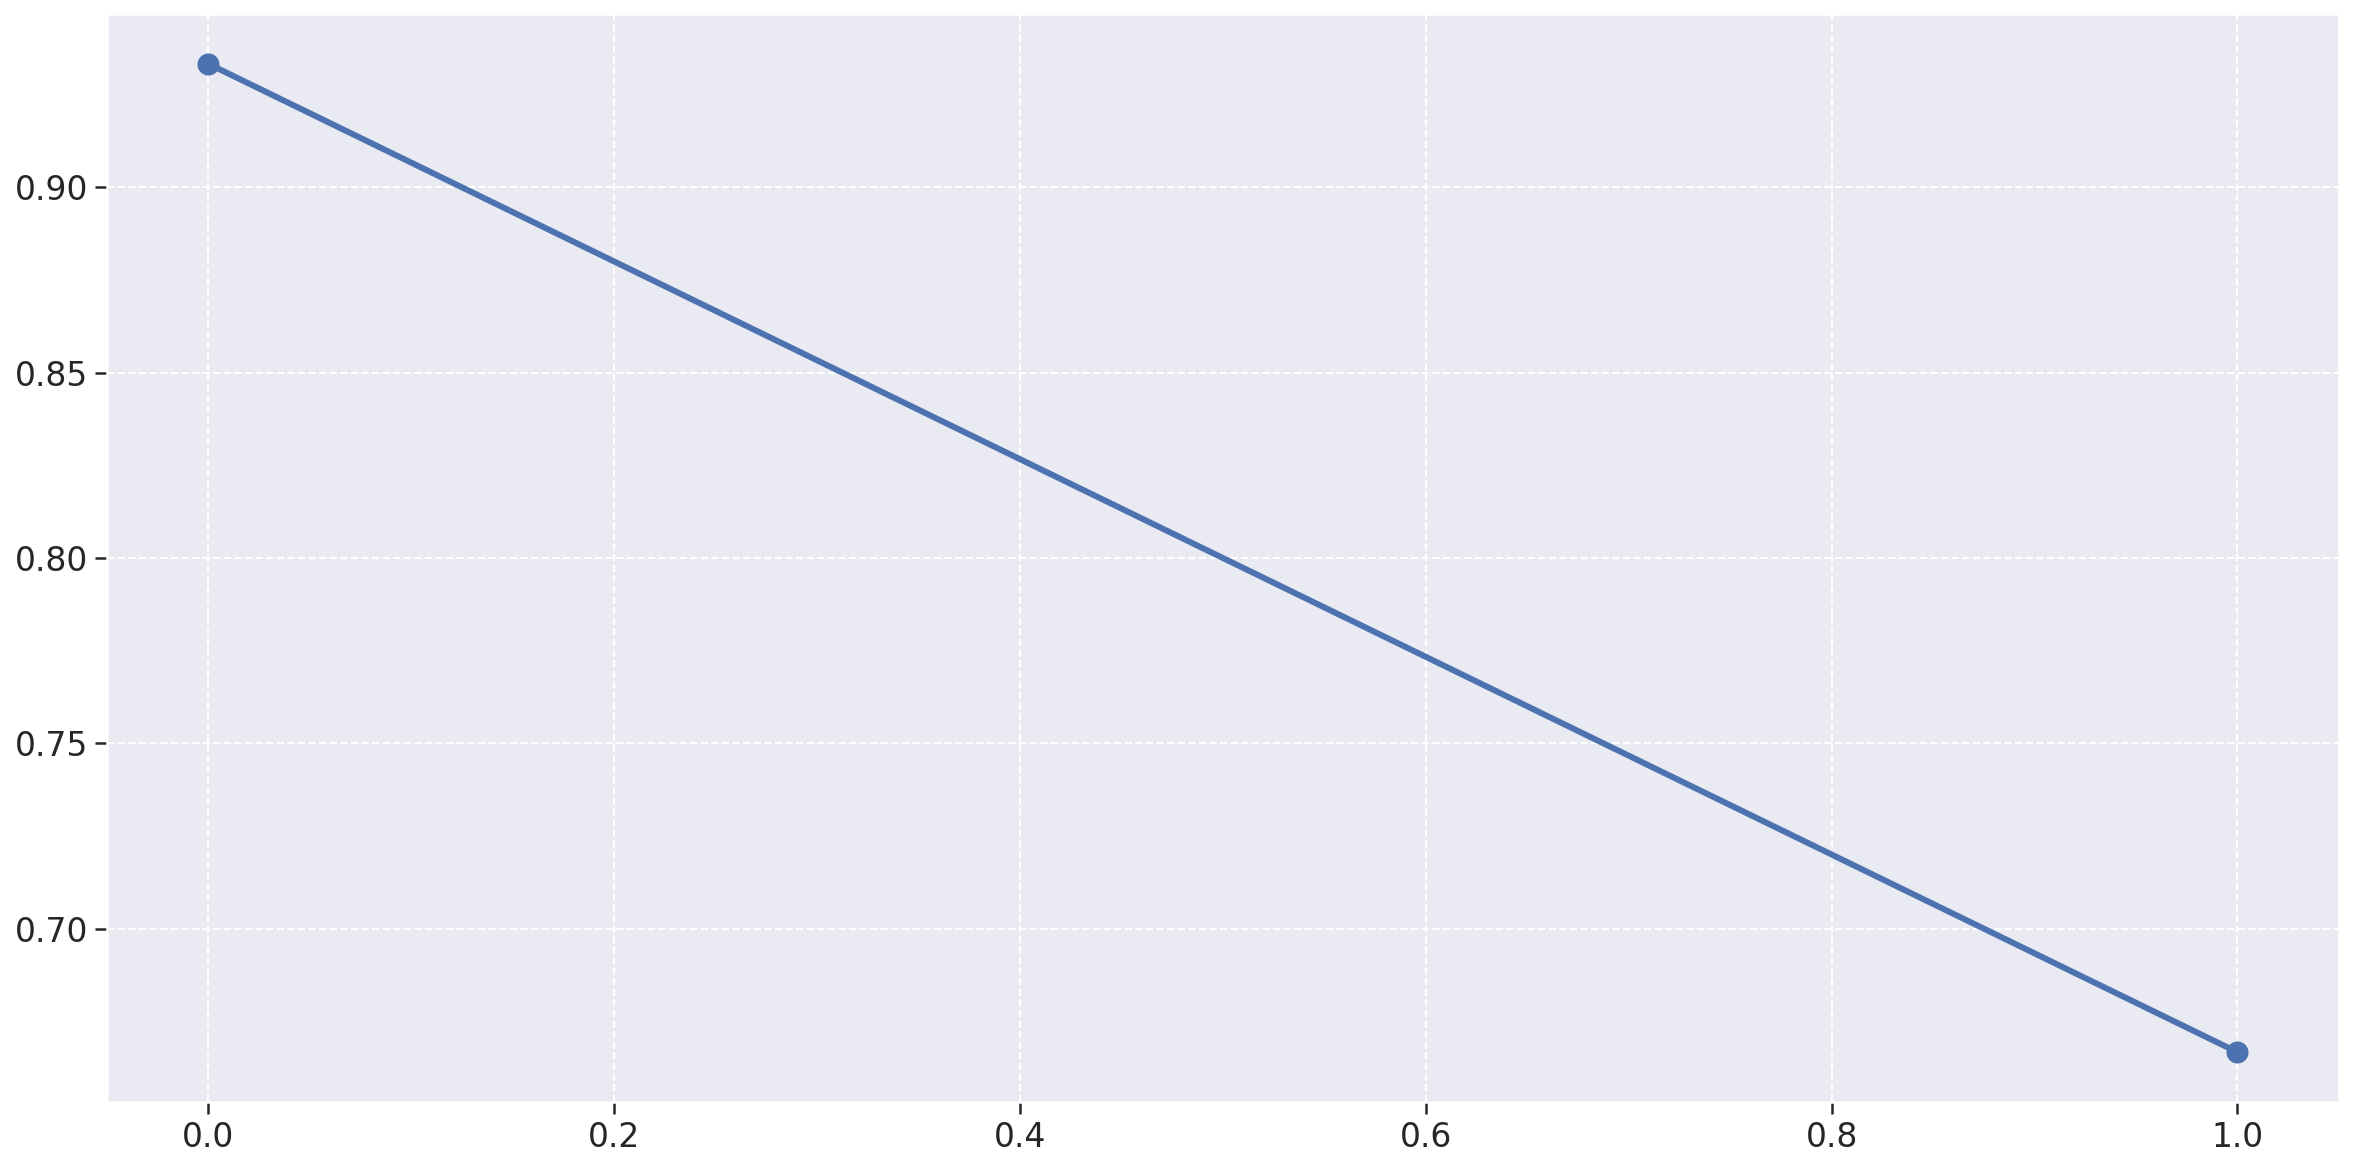

In [81]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['m1'], linewidth=3, marker='o', markersize=10)

# M2

## Archives

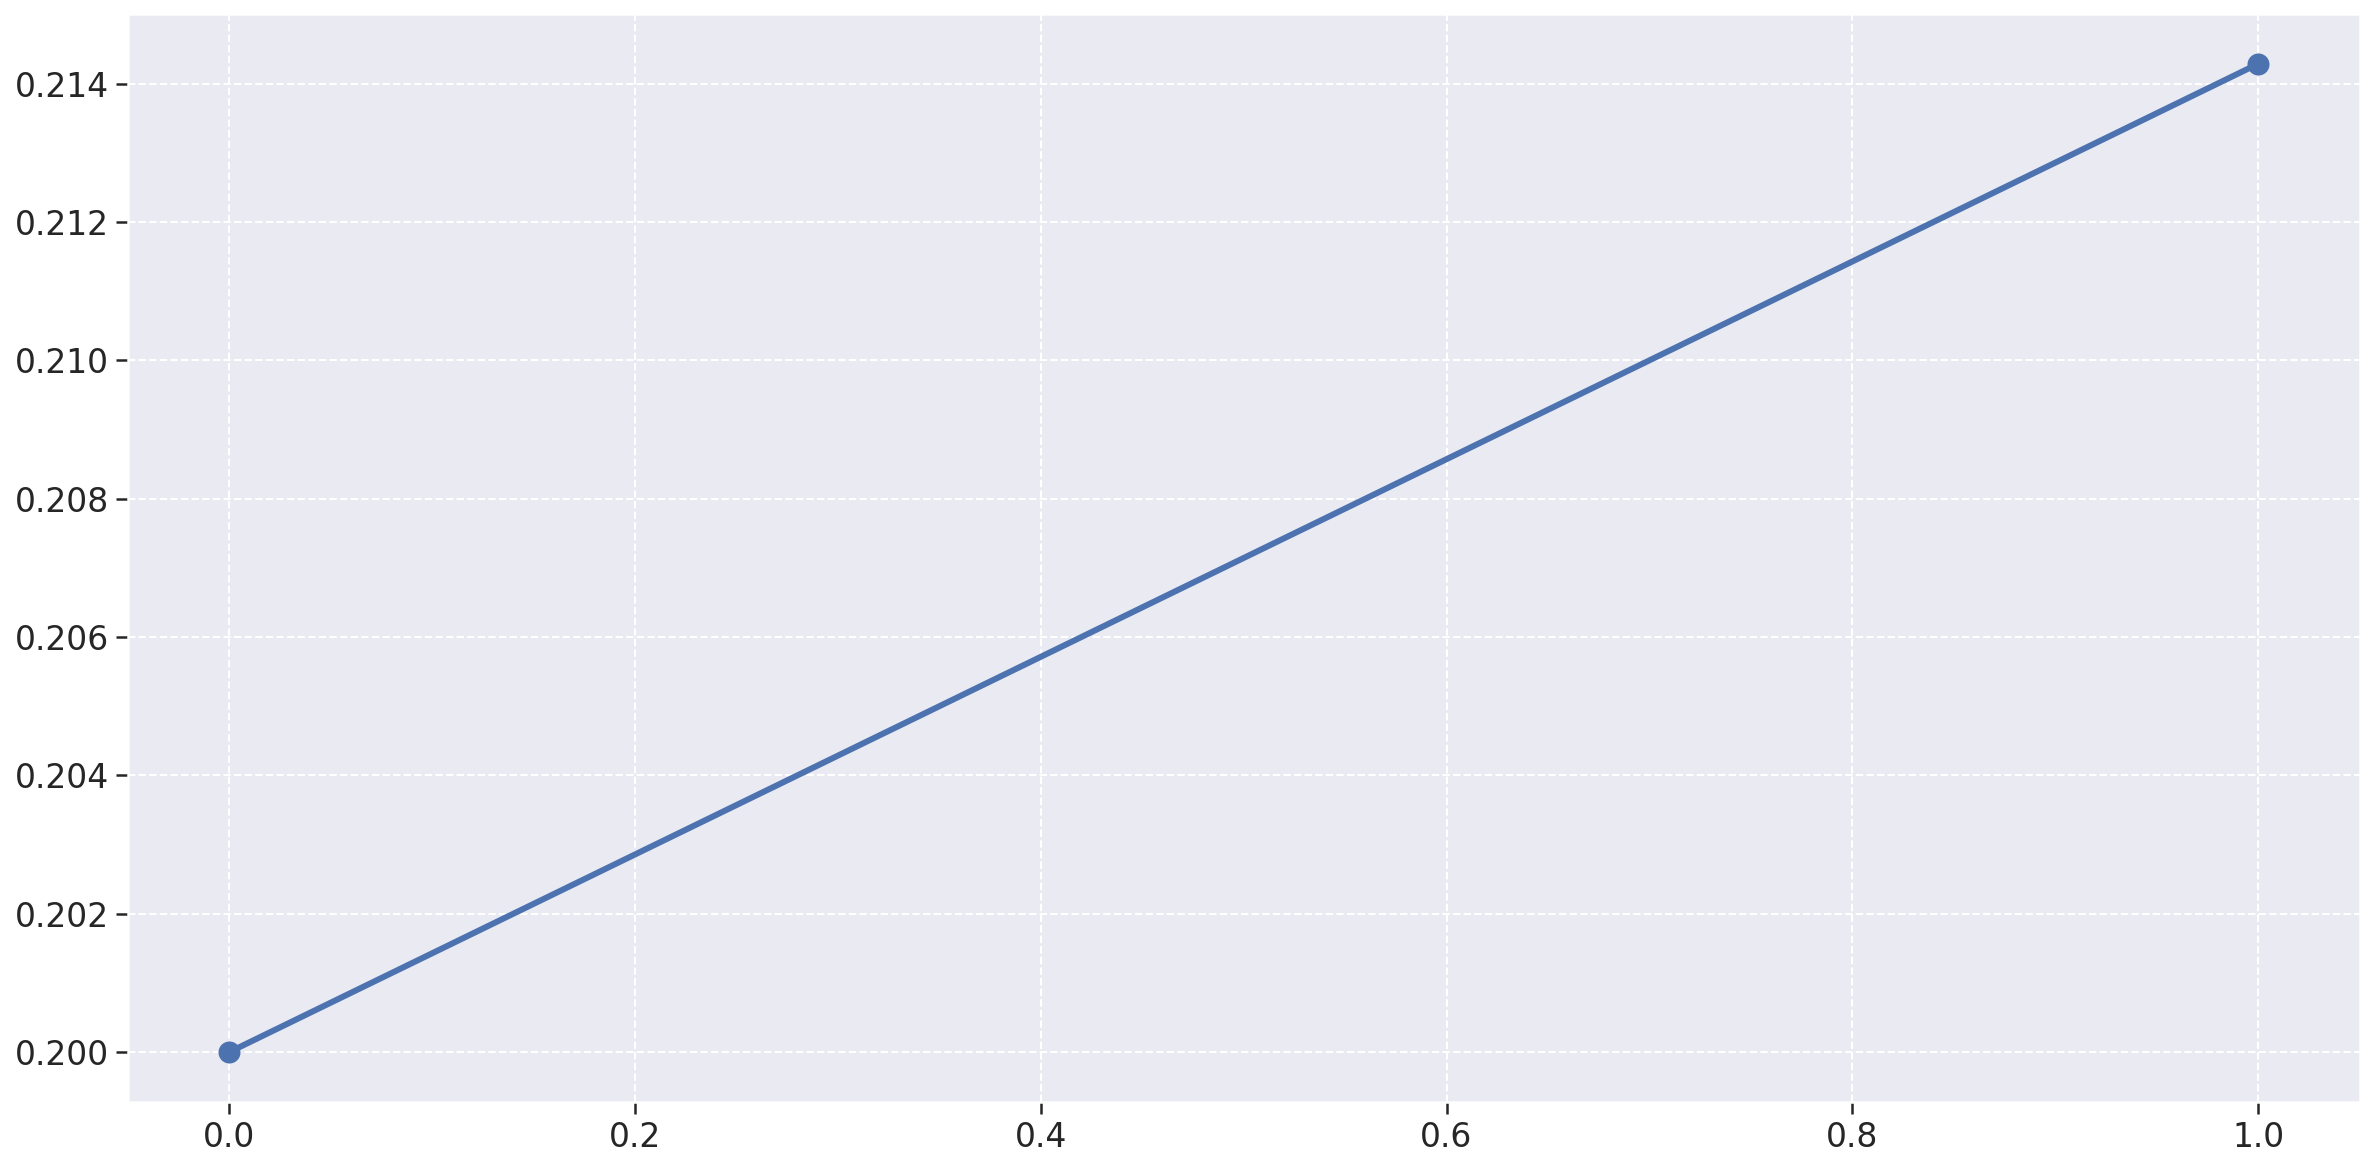

In [93]:
fig = plt.figure(figsize=(20, 10))

plt.plot(archives_metrics['m2'], linewidth=3, marker='o', markersize=10)

## Profile

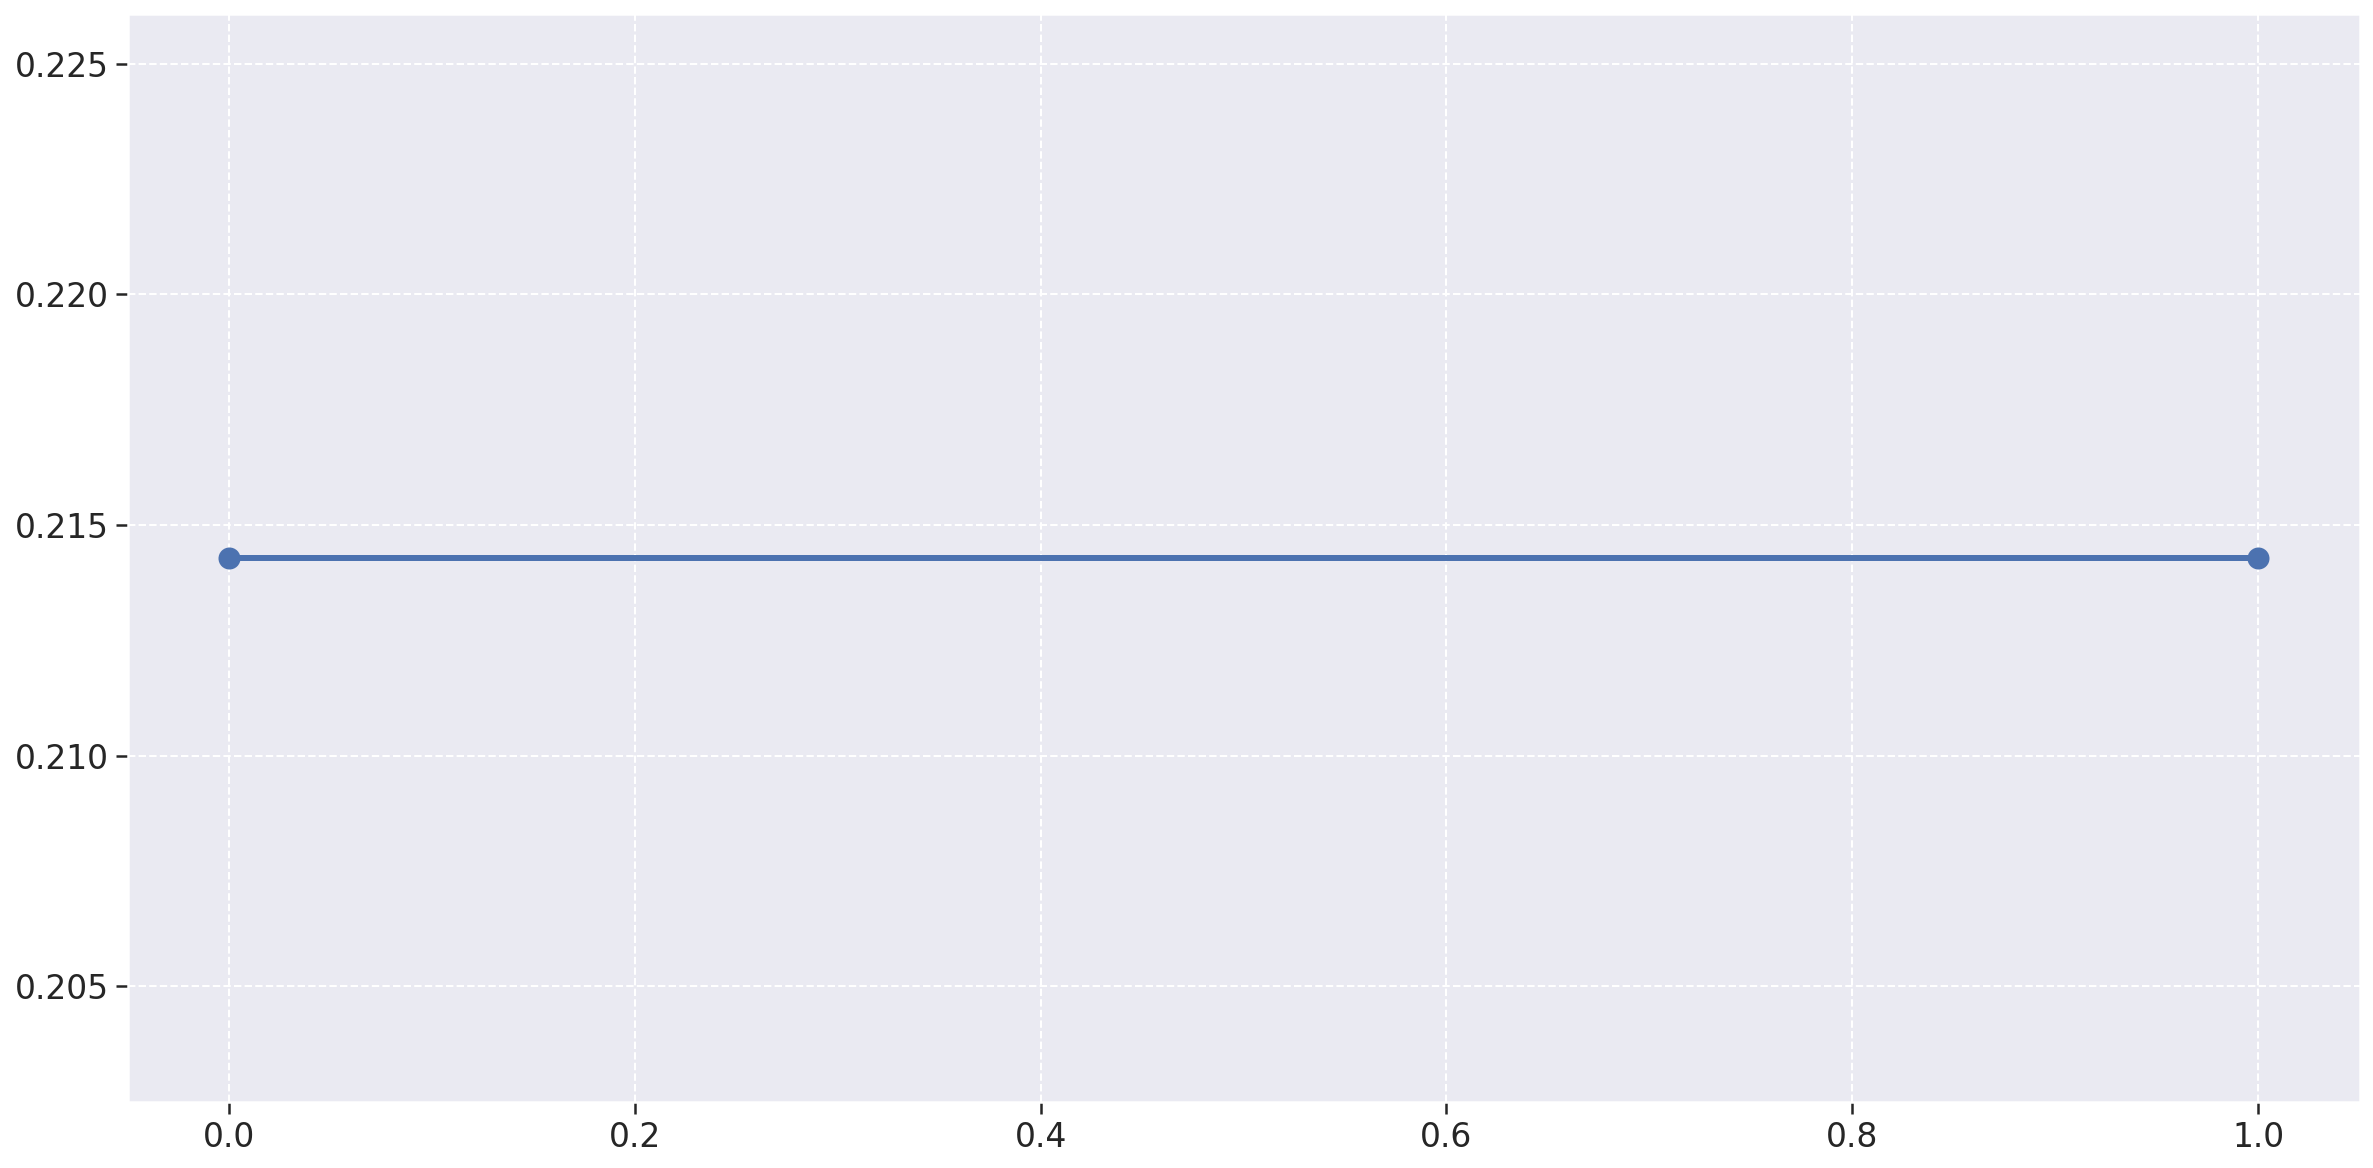

In [94]:
fig = plt.figure(figsize=(20, 10))

plt.plot(profile_metrics['m2'], linewidth=3, marker='o', markersize=10)

## Frontend

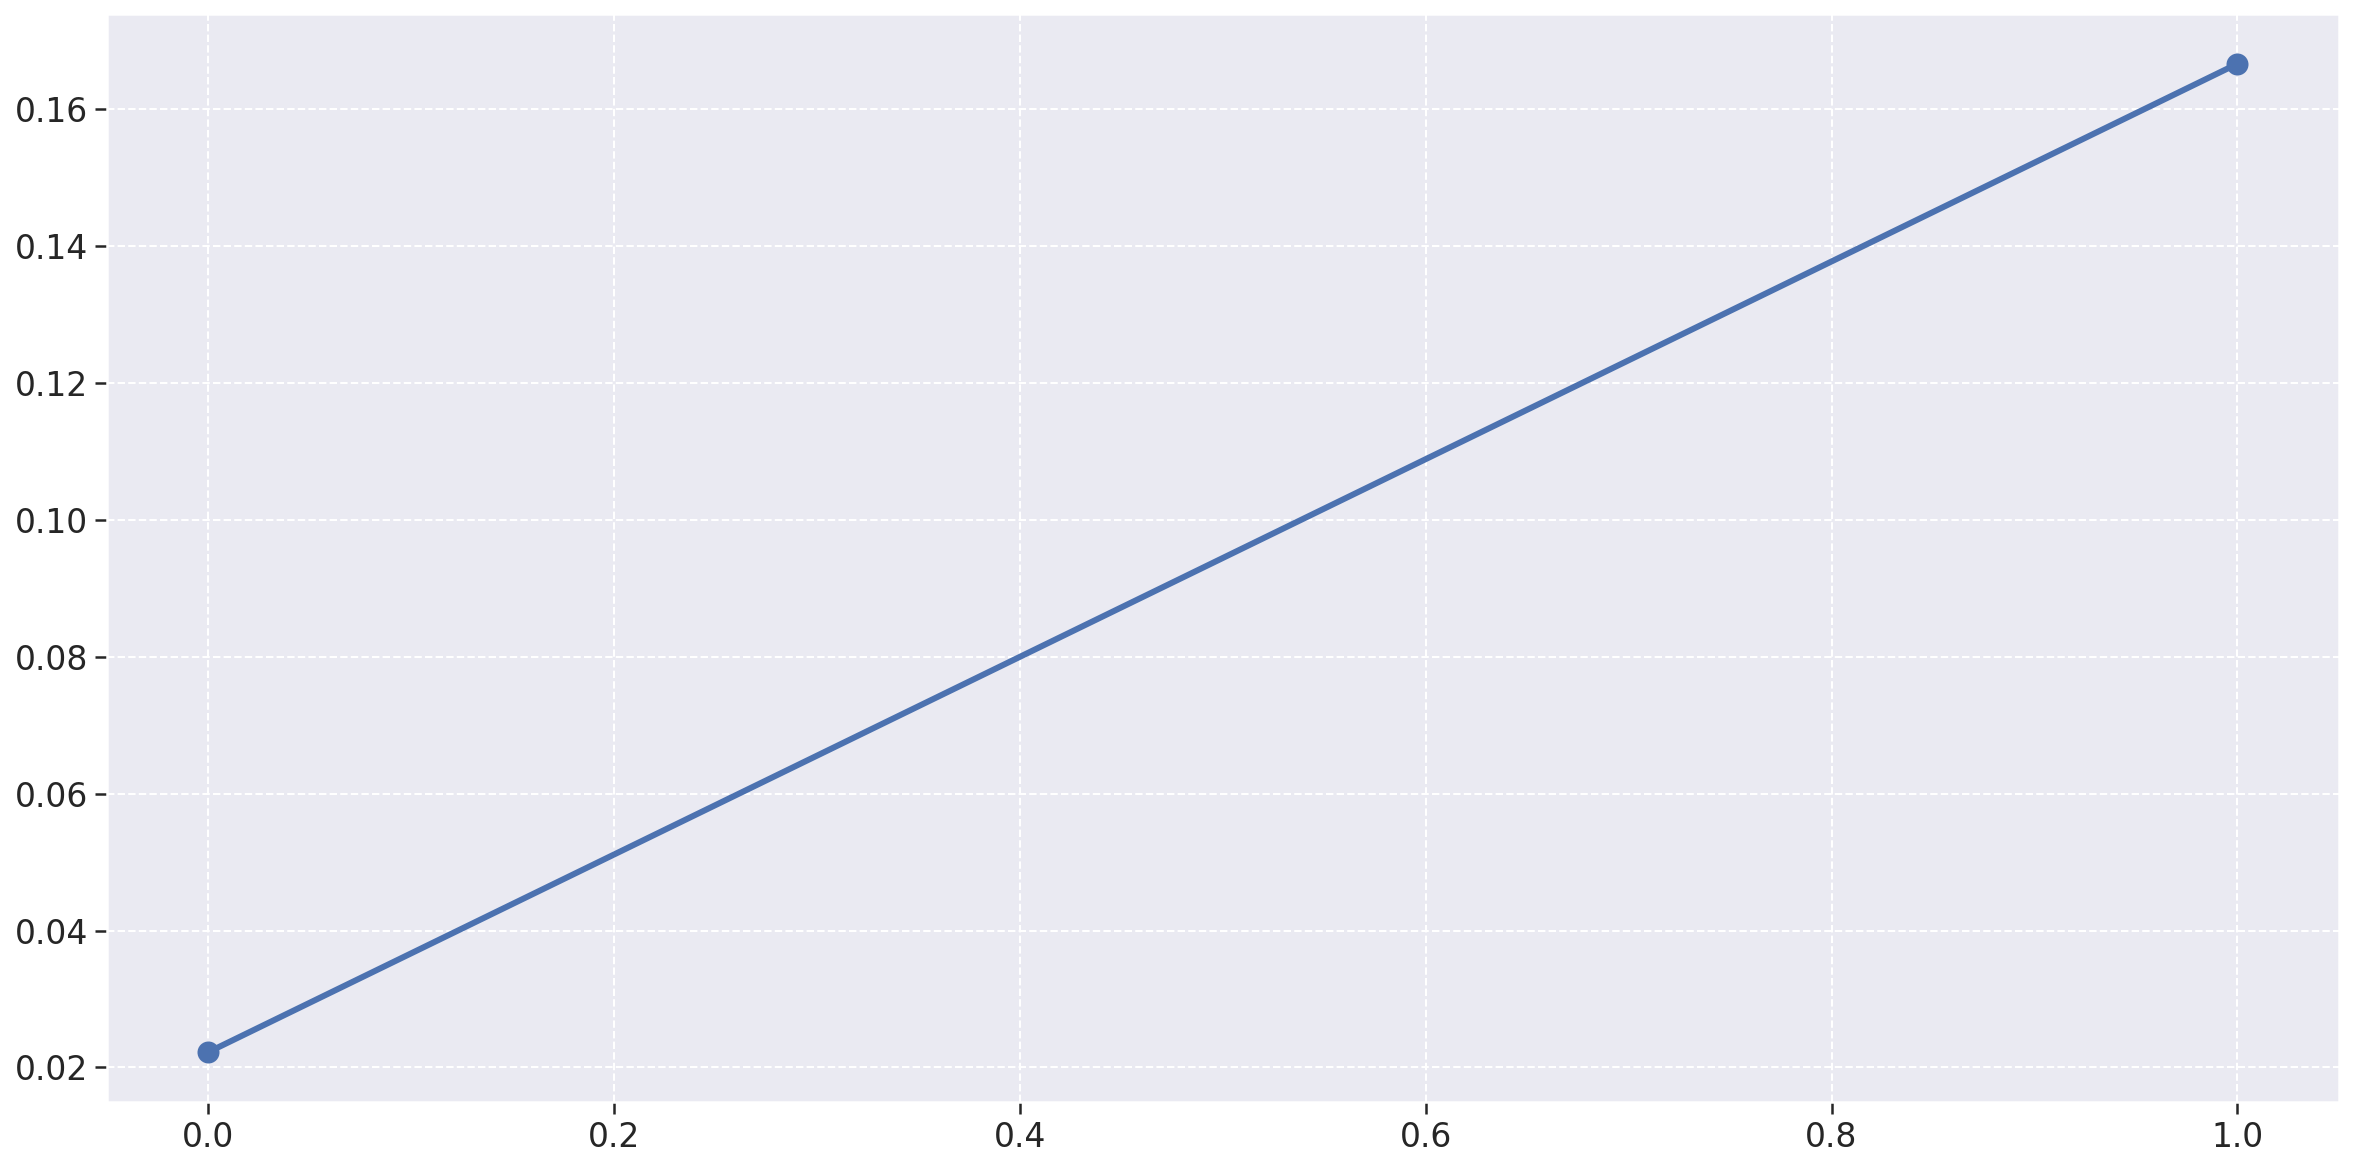

In [95]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['m2'], linewidth=3, marker='o', markersize=10)

# M3

## Archives

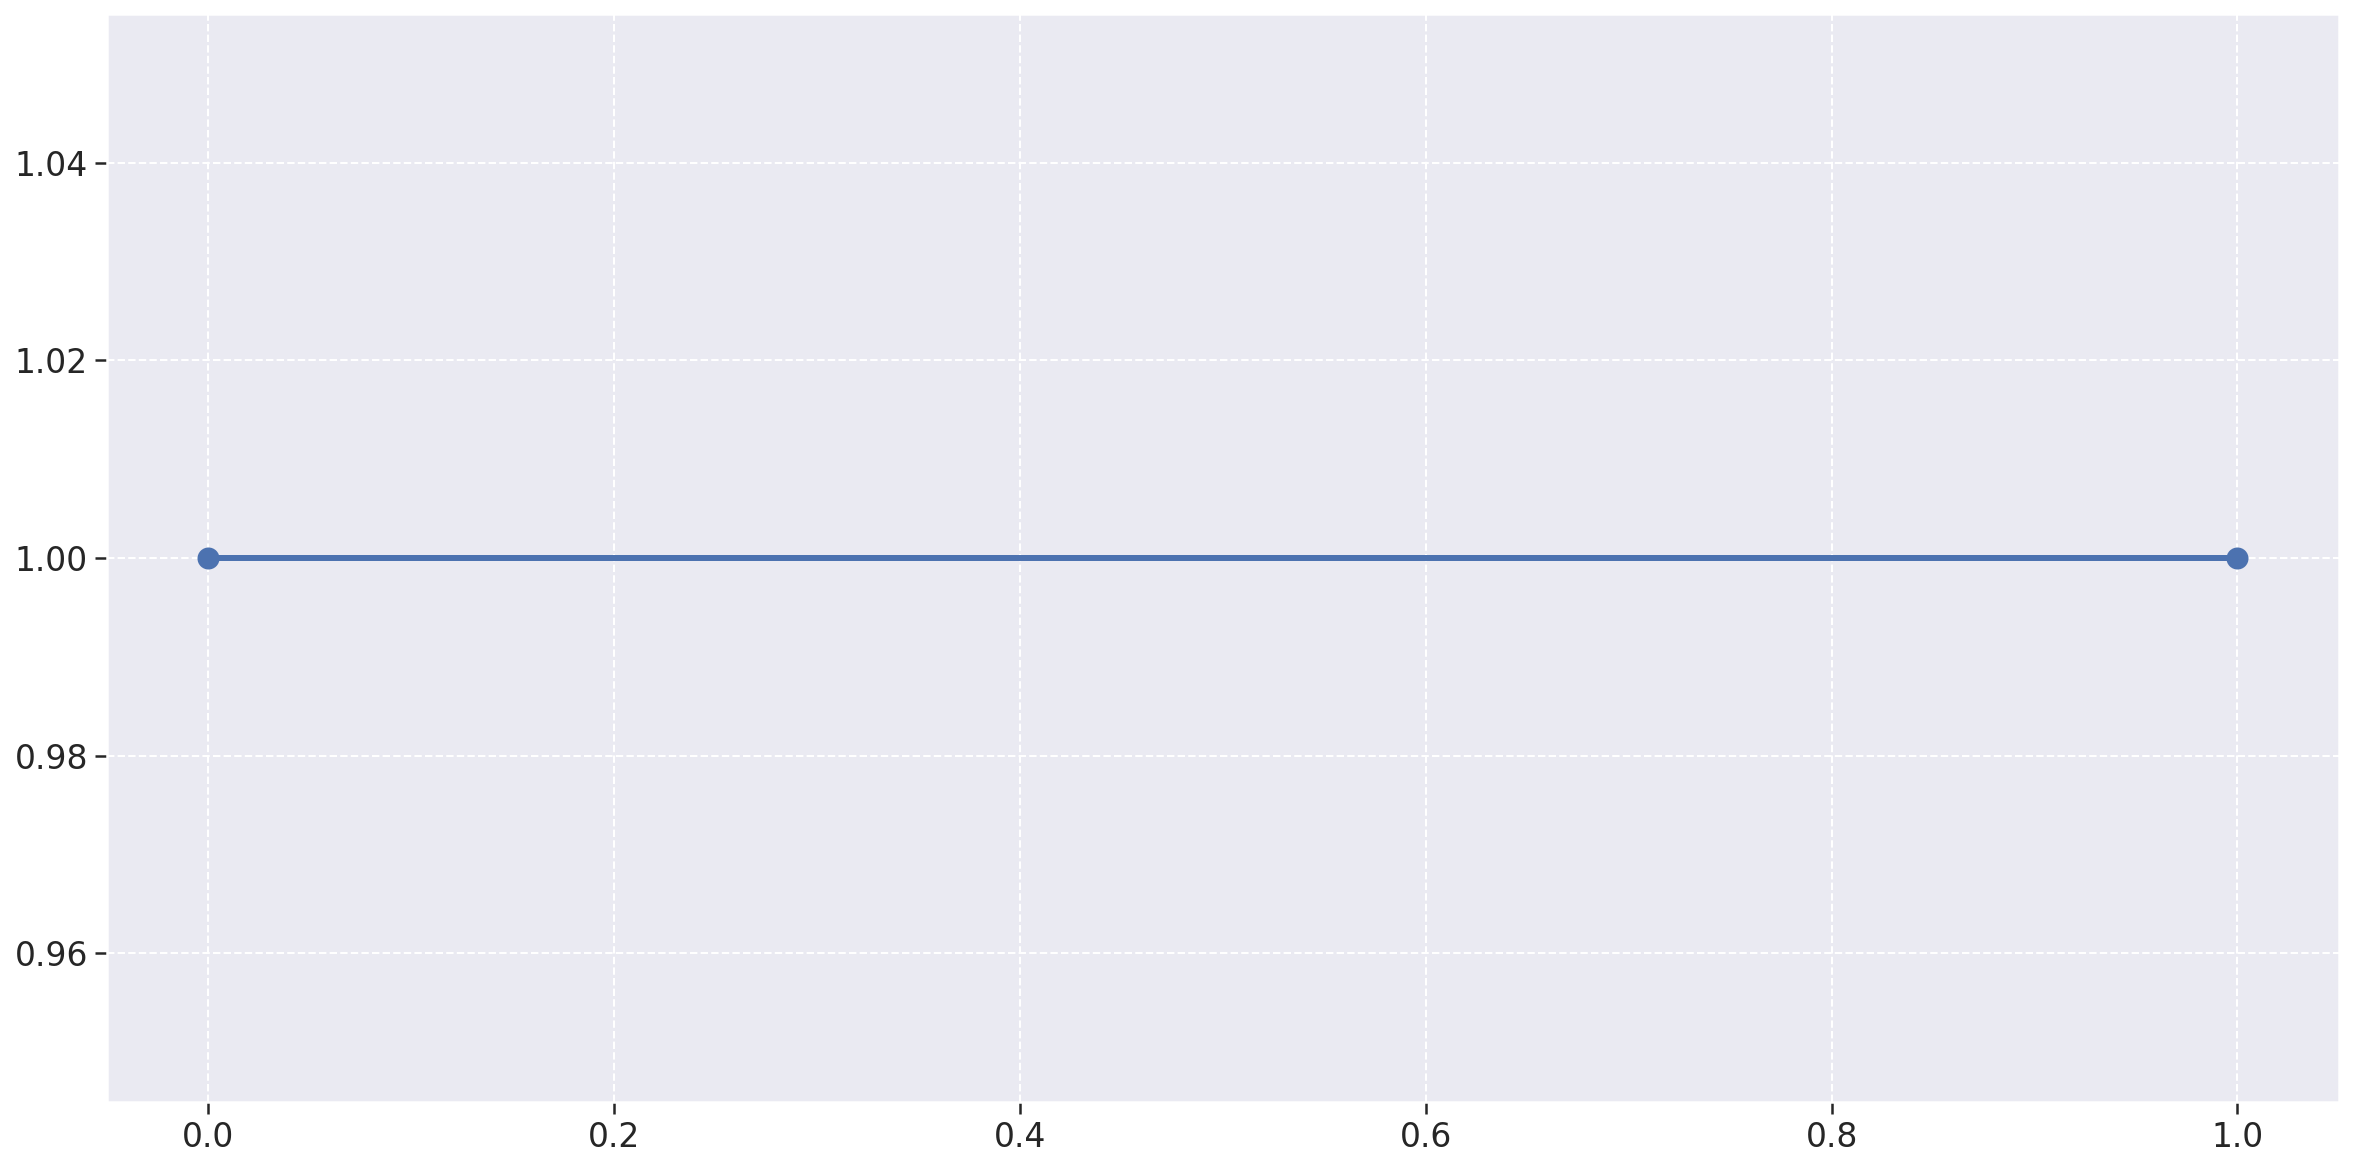

In [89]:
fig = plt.figure(figsize=(20, 10))

plt.plot(archives_metrics['m3'], linewidth=3, marker='o', markersize=10)

## Profile

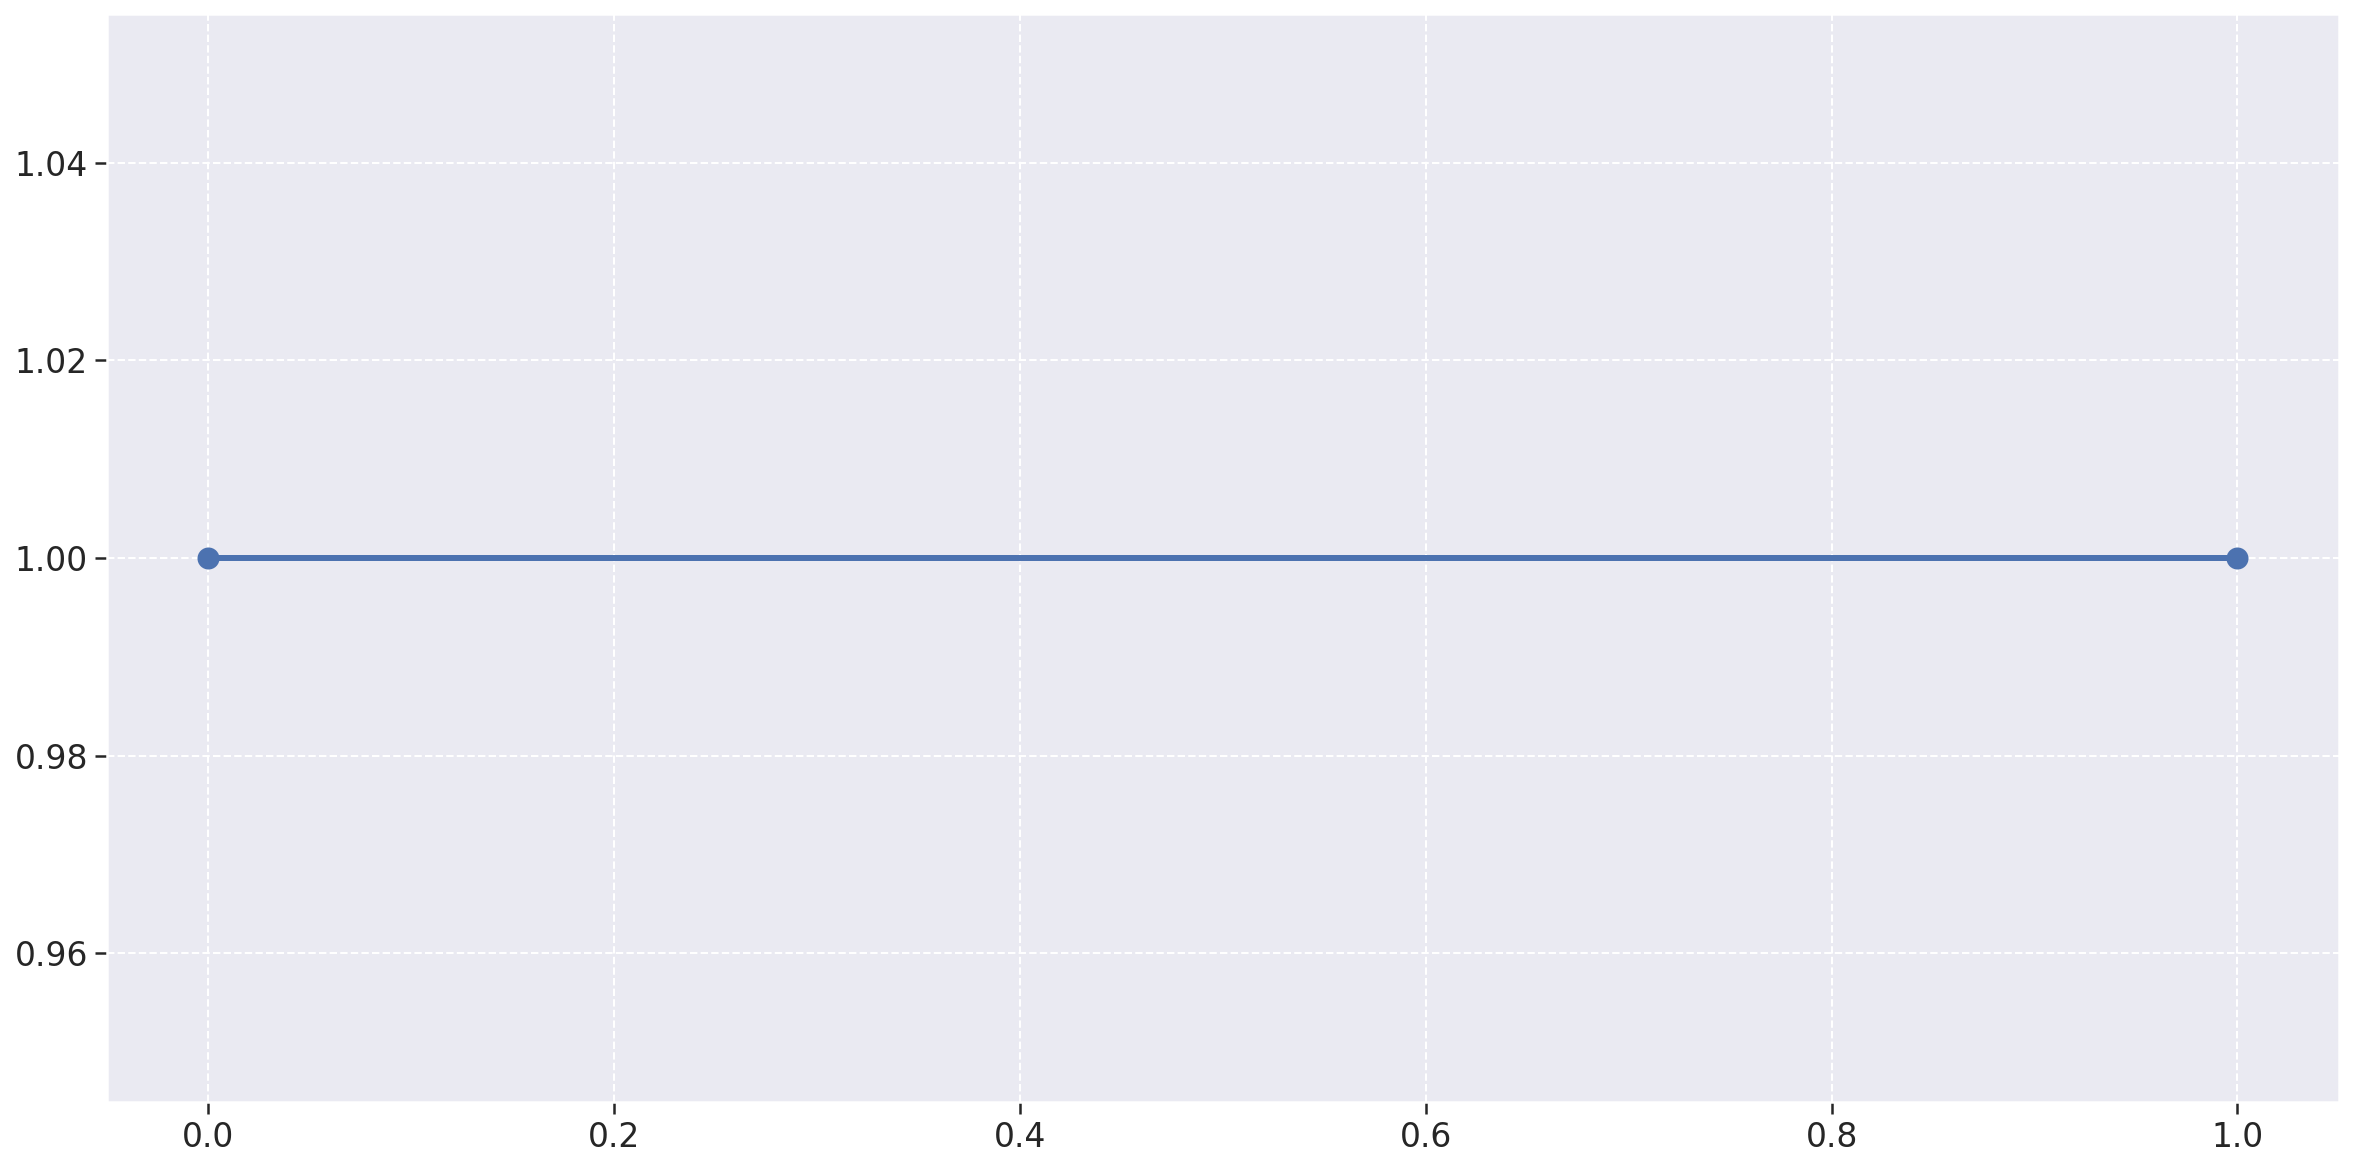

In [90]:
fig = plt.figure(figsize=(20, 10))

plt.plot(profile_metrics['m3'], linewidth=3, marker='o', markersize=10)

# Frontend

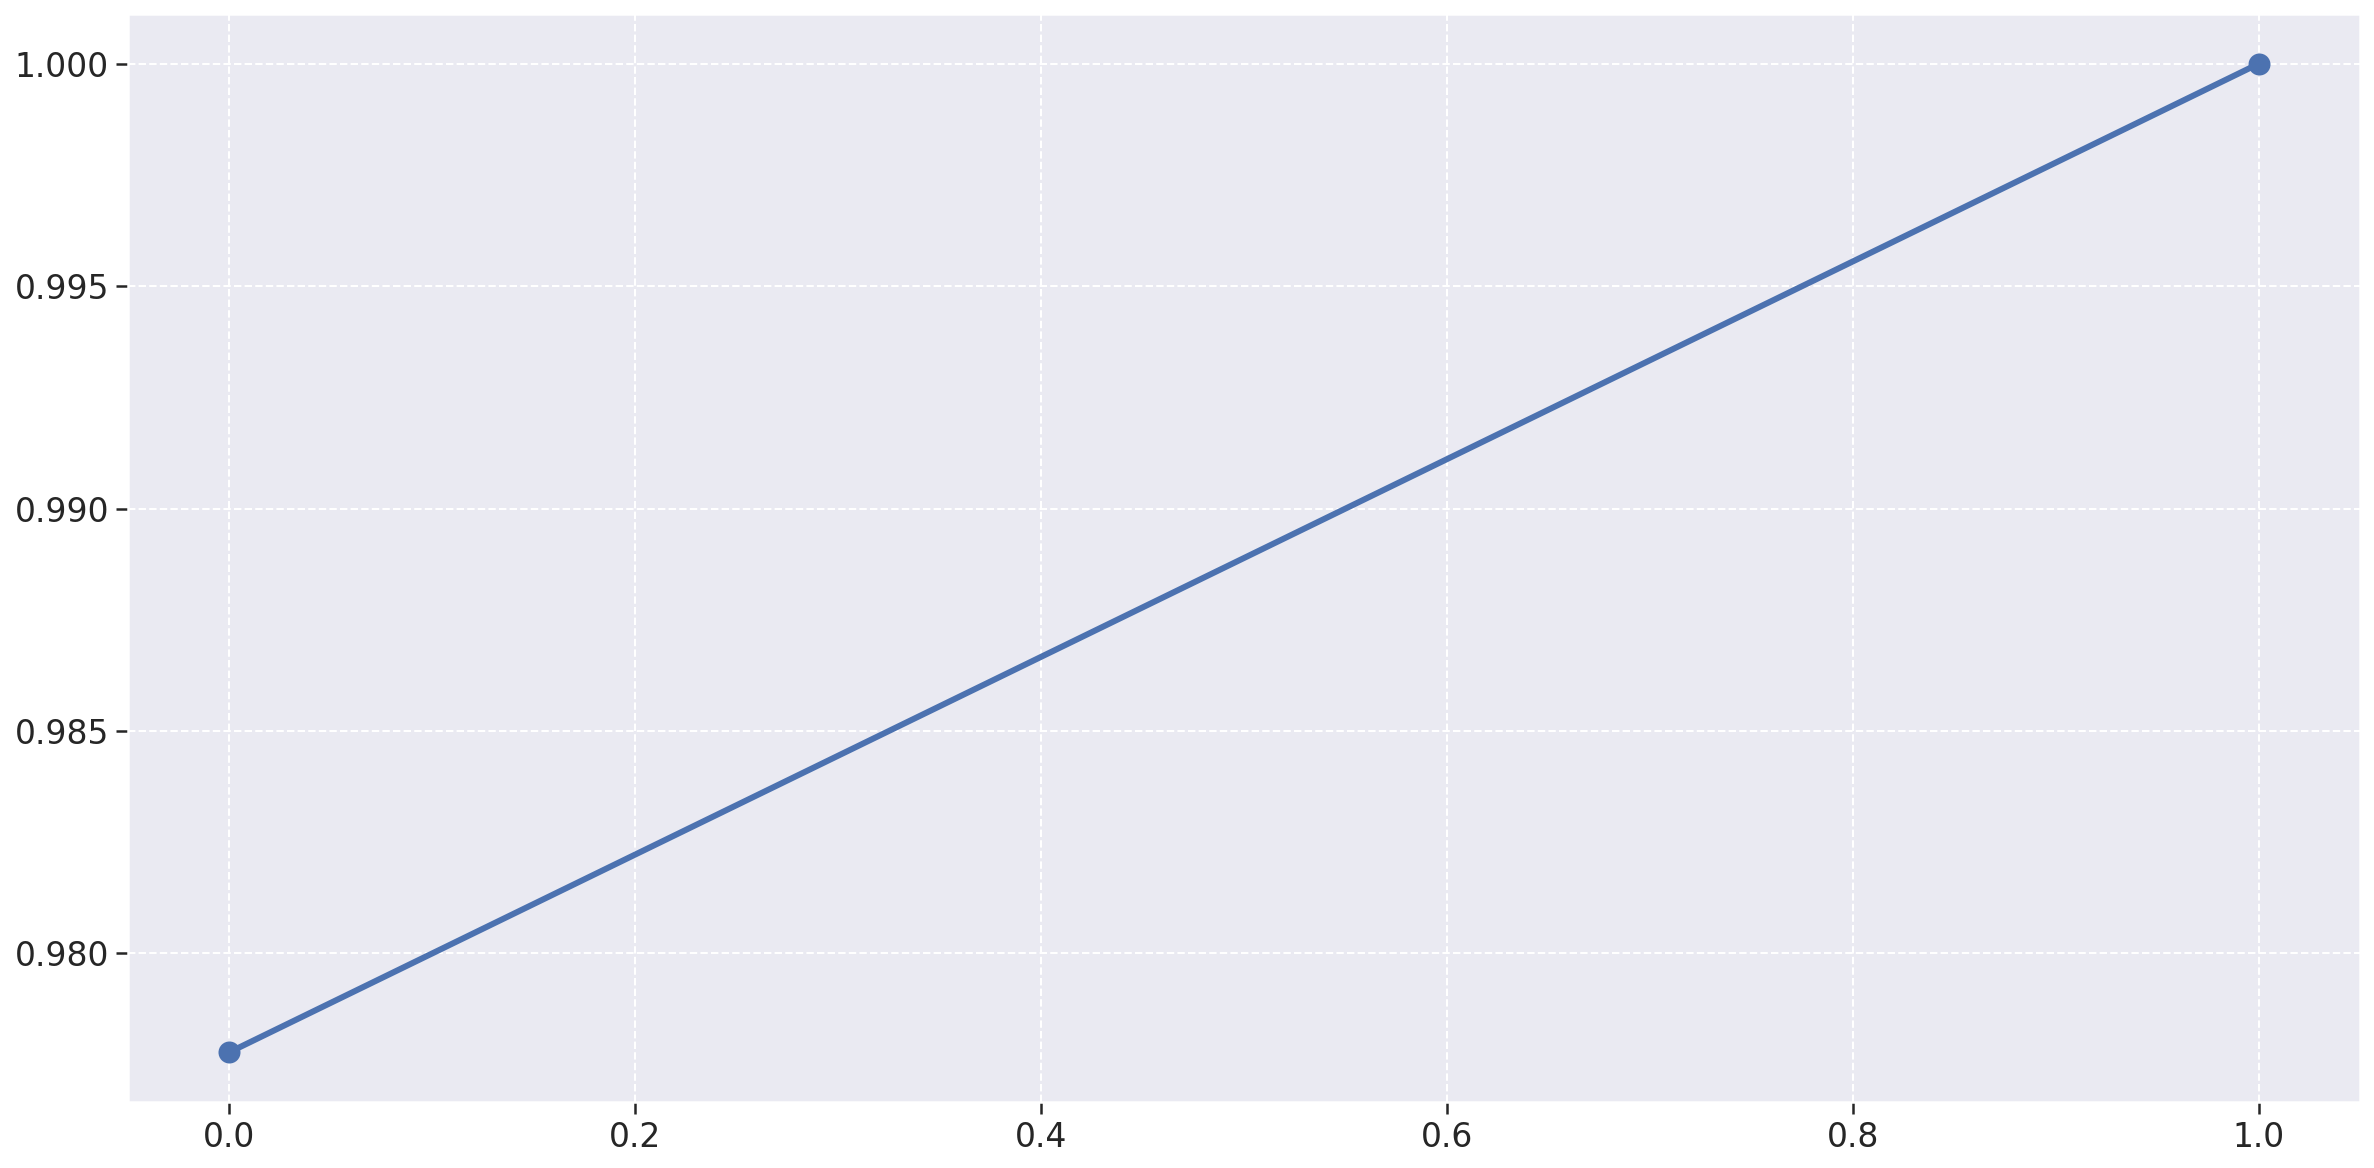

In [91]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['m3'], linewidth=3, marker='o', markersize=10)

## Archives

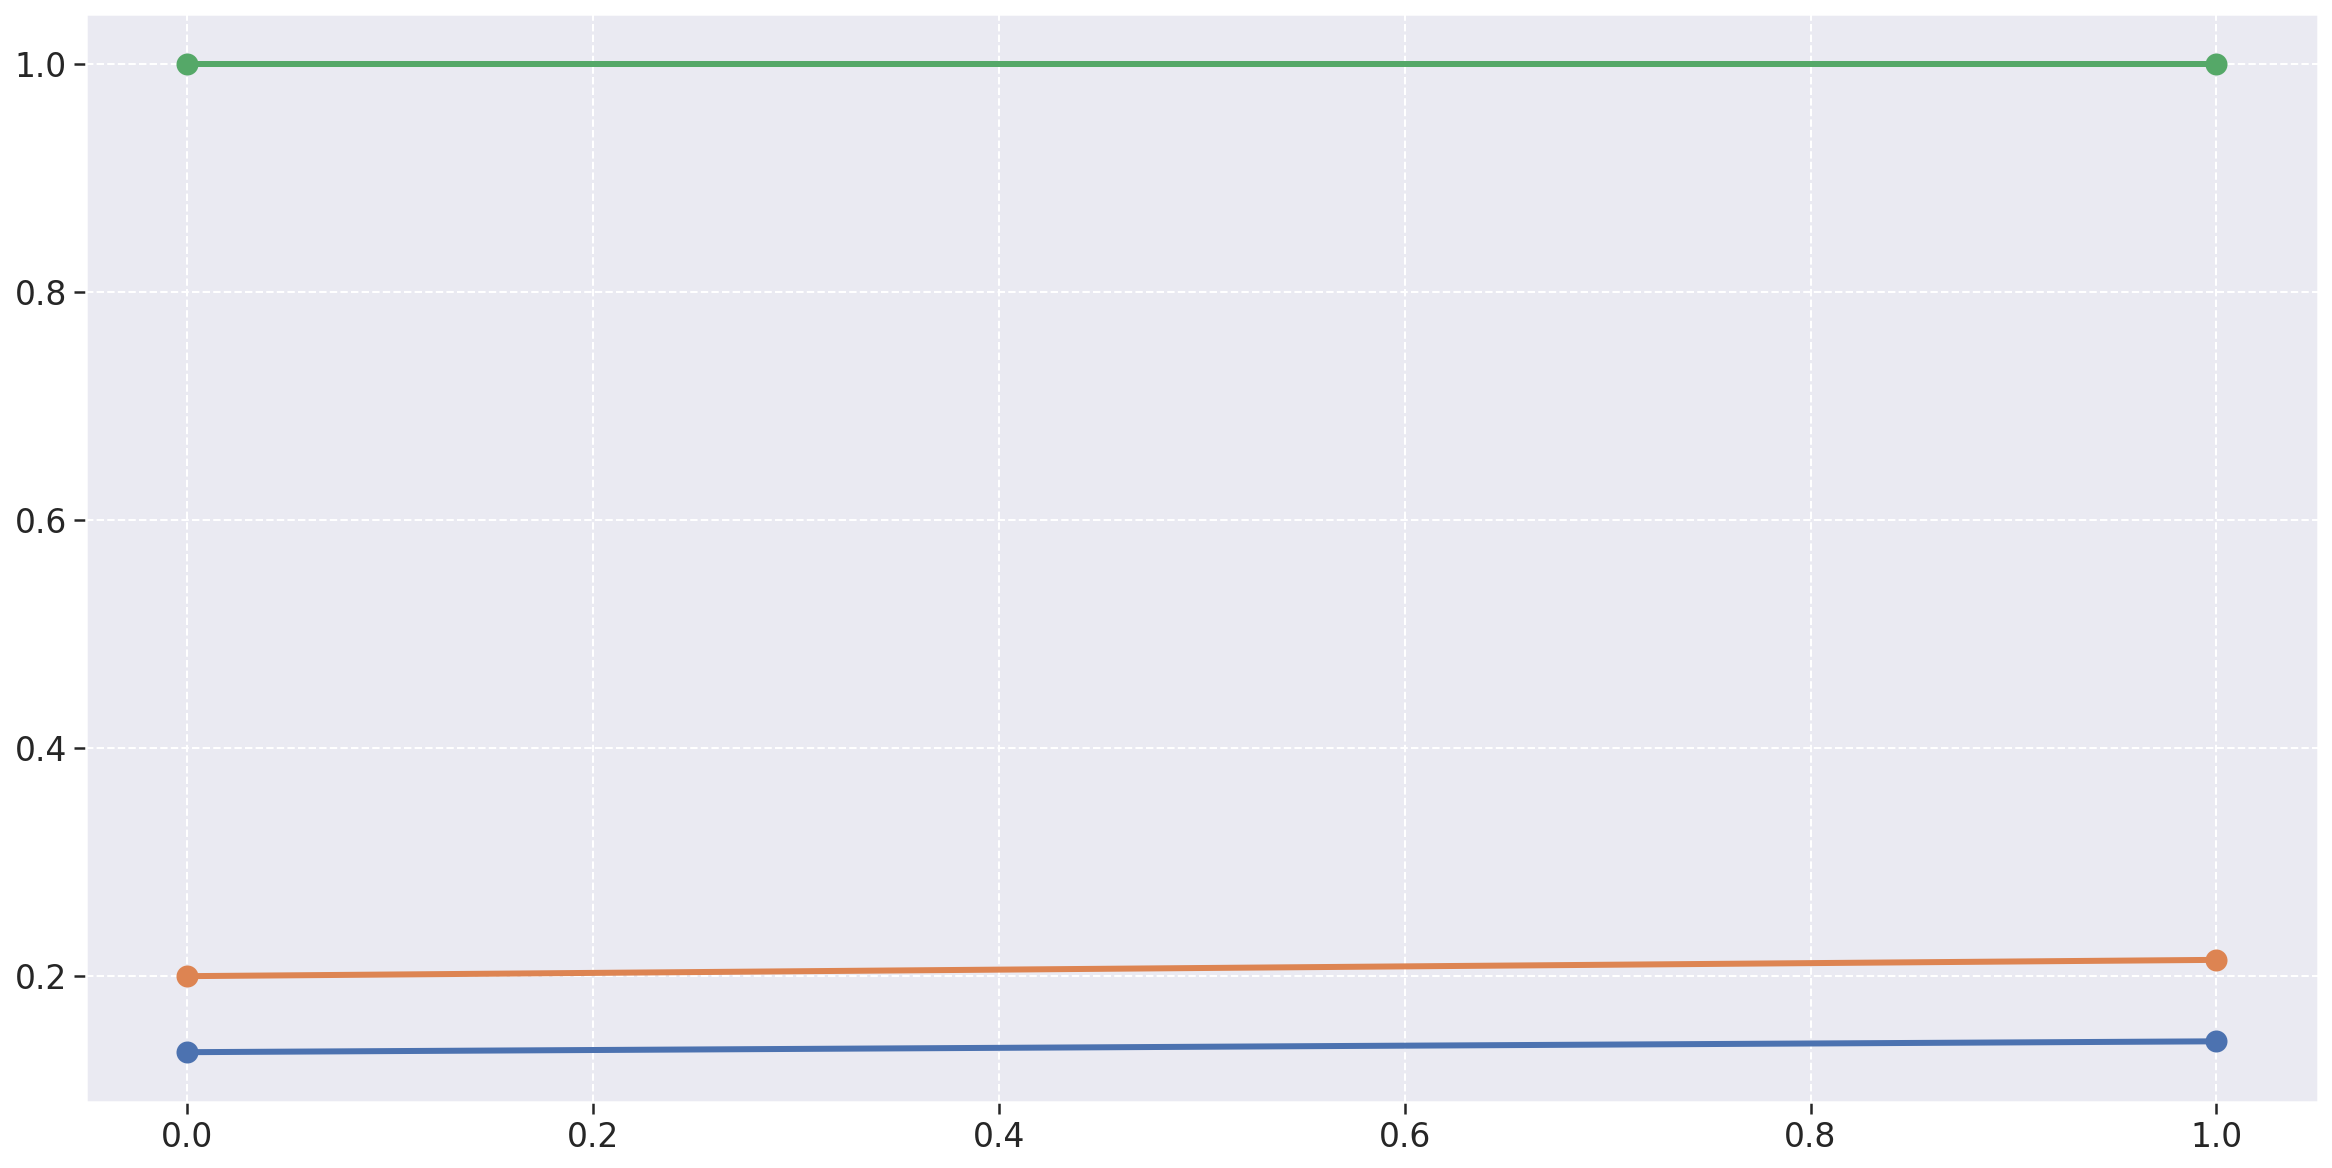

In [96]:
fig = plt.figure(figsize=(20, 10))

plt.plot(archives_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(archives_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(archives_metrics['m3'], linewidth=3, marker='o', markersize=10)

## Profile

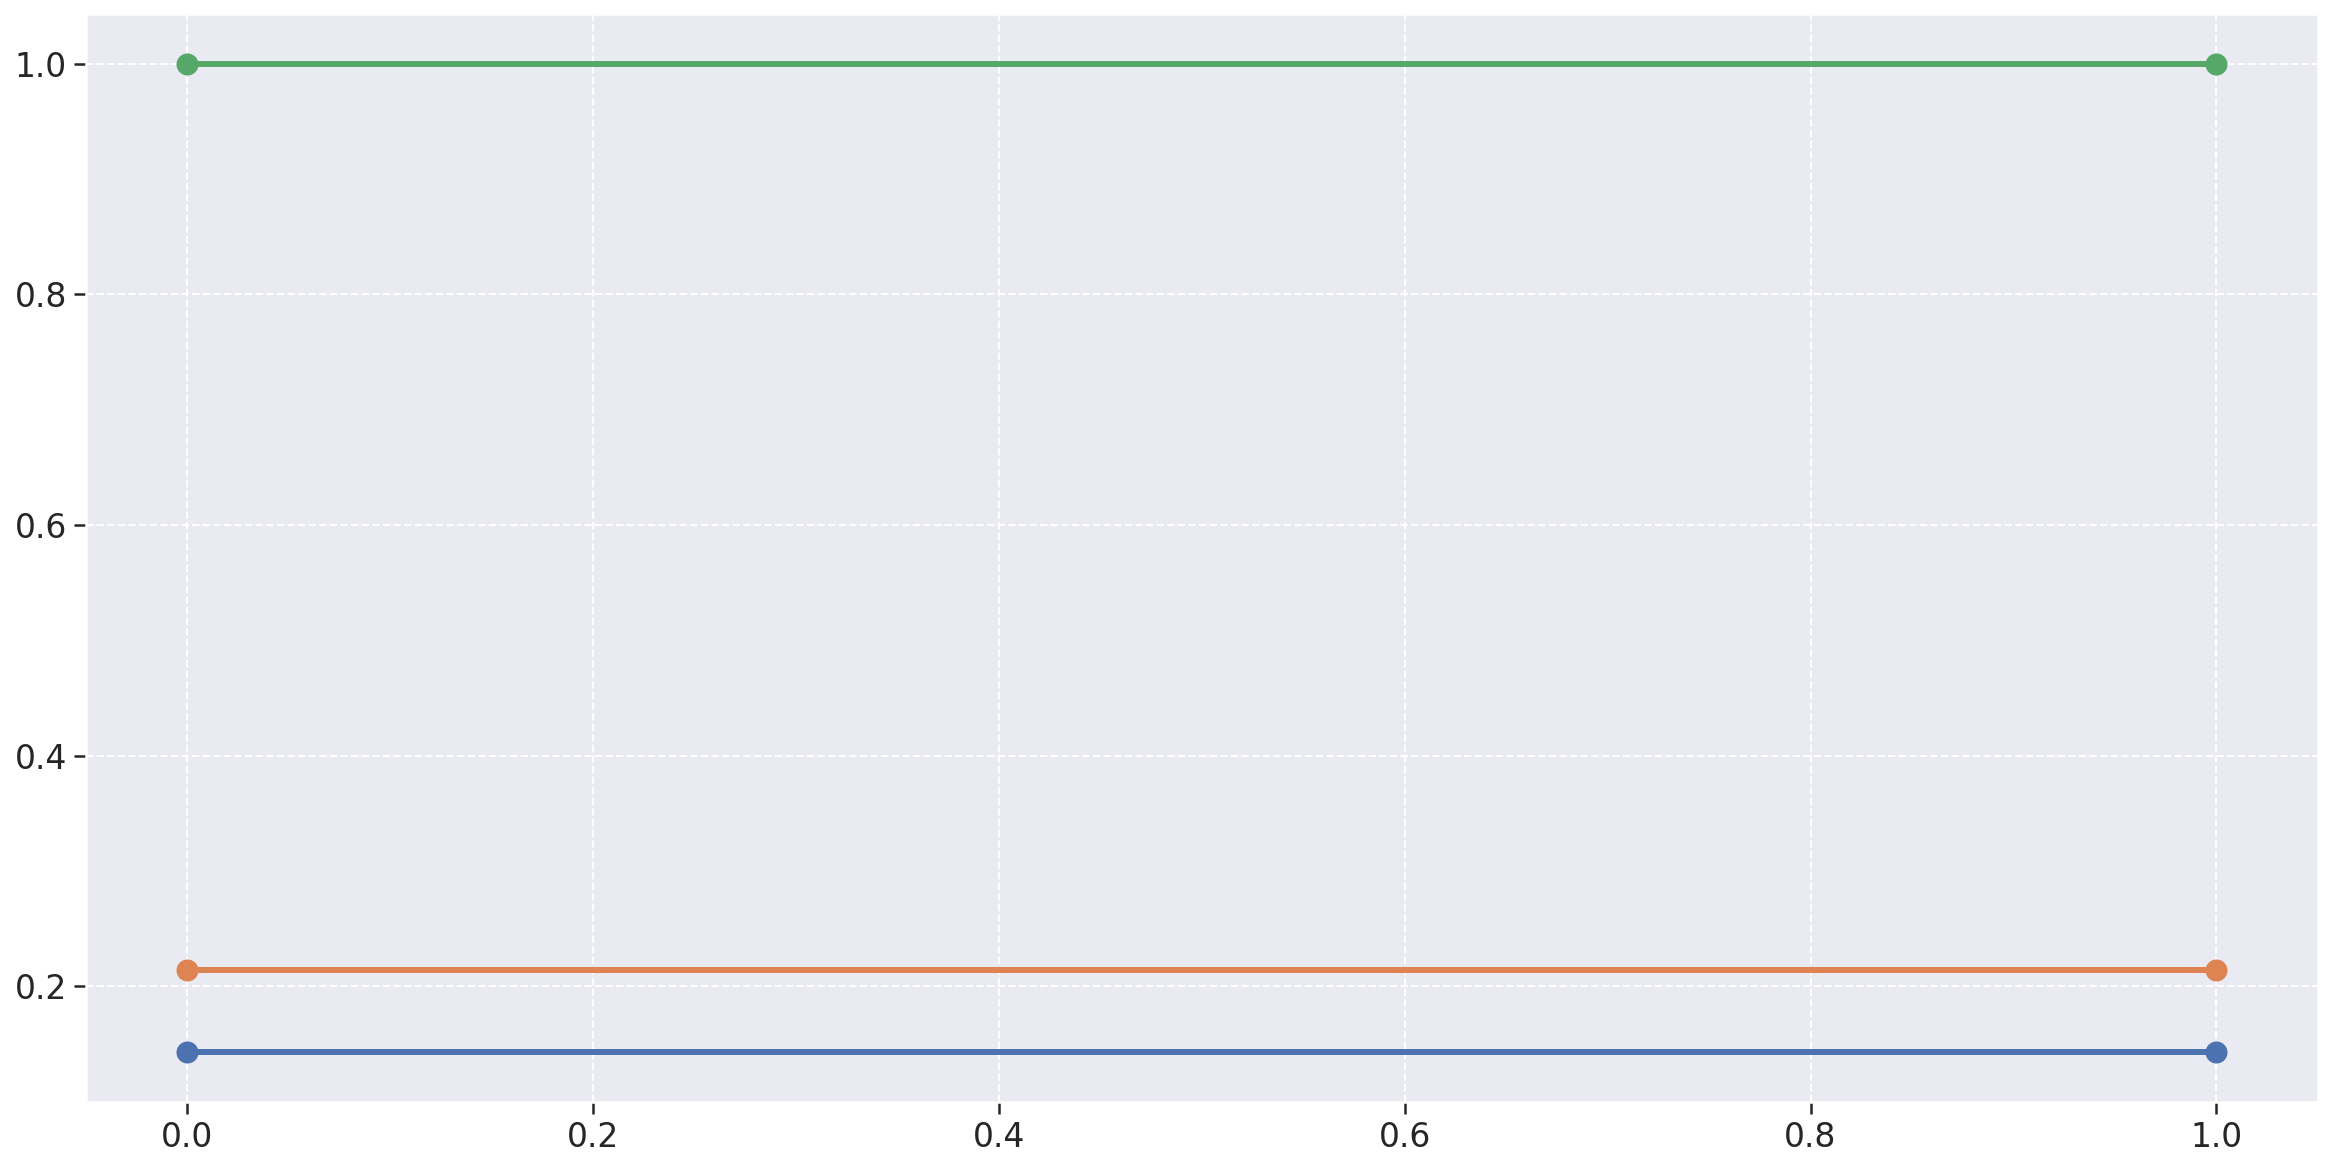

In [97]:
fig = plt.figure(figsize=(20, 10))

plt.plot(profile_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m3'], linewidth=3, marker='o', markersize=10)

## Frontend

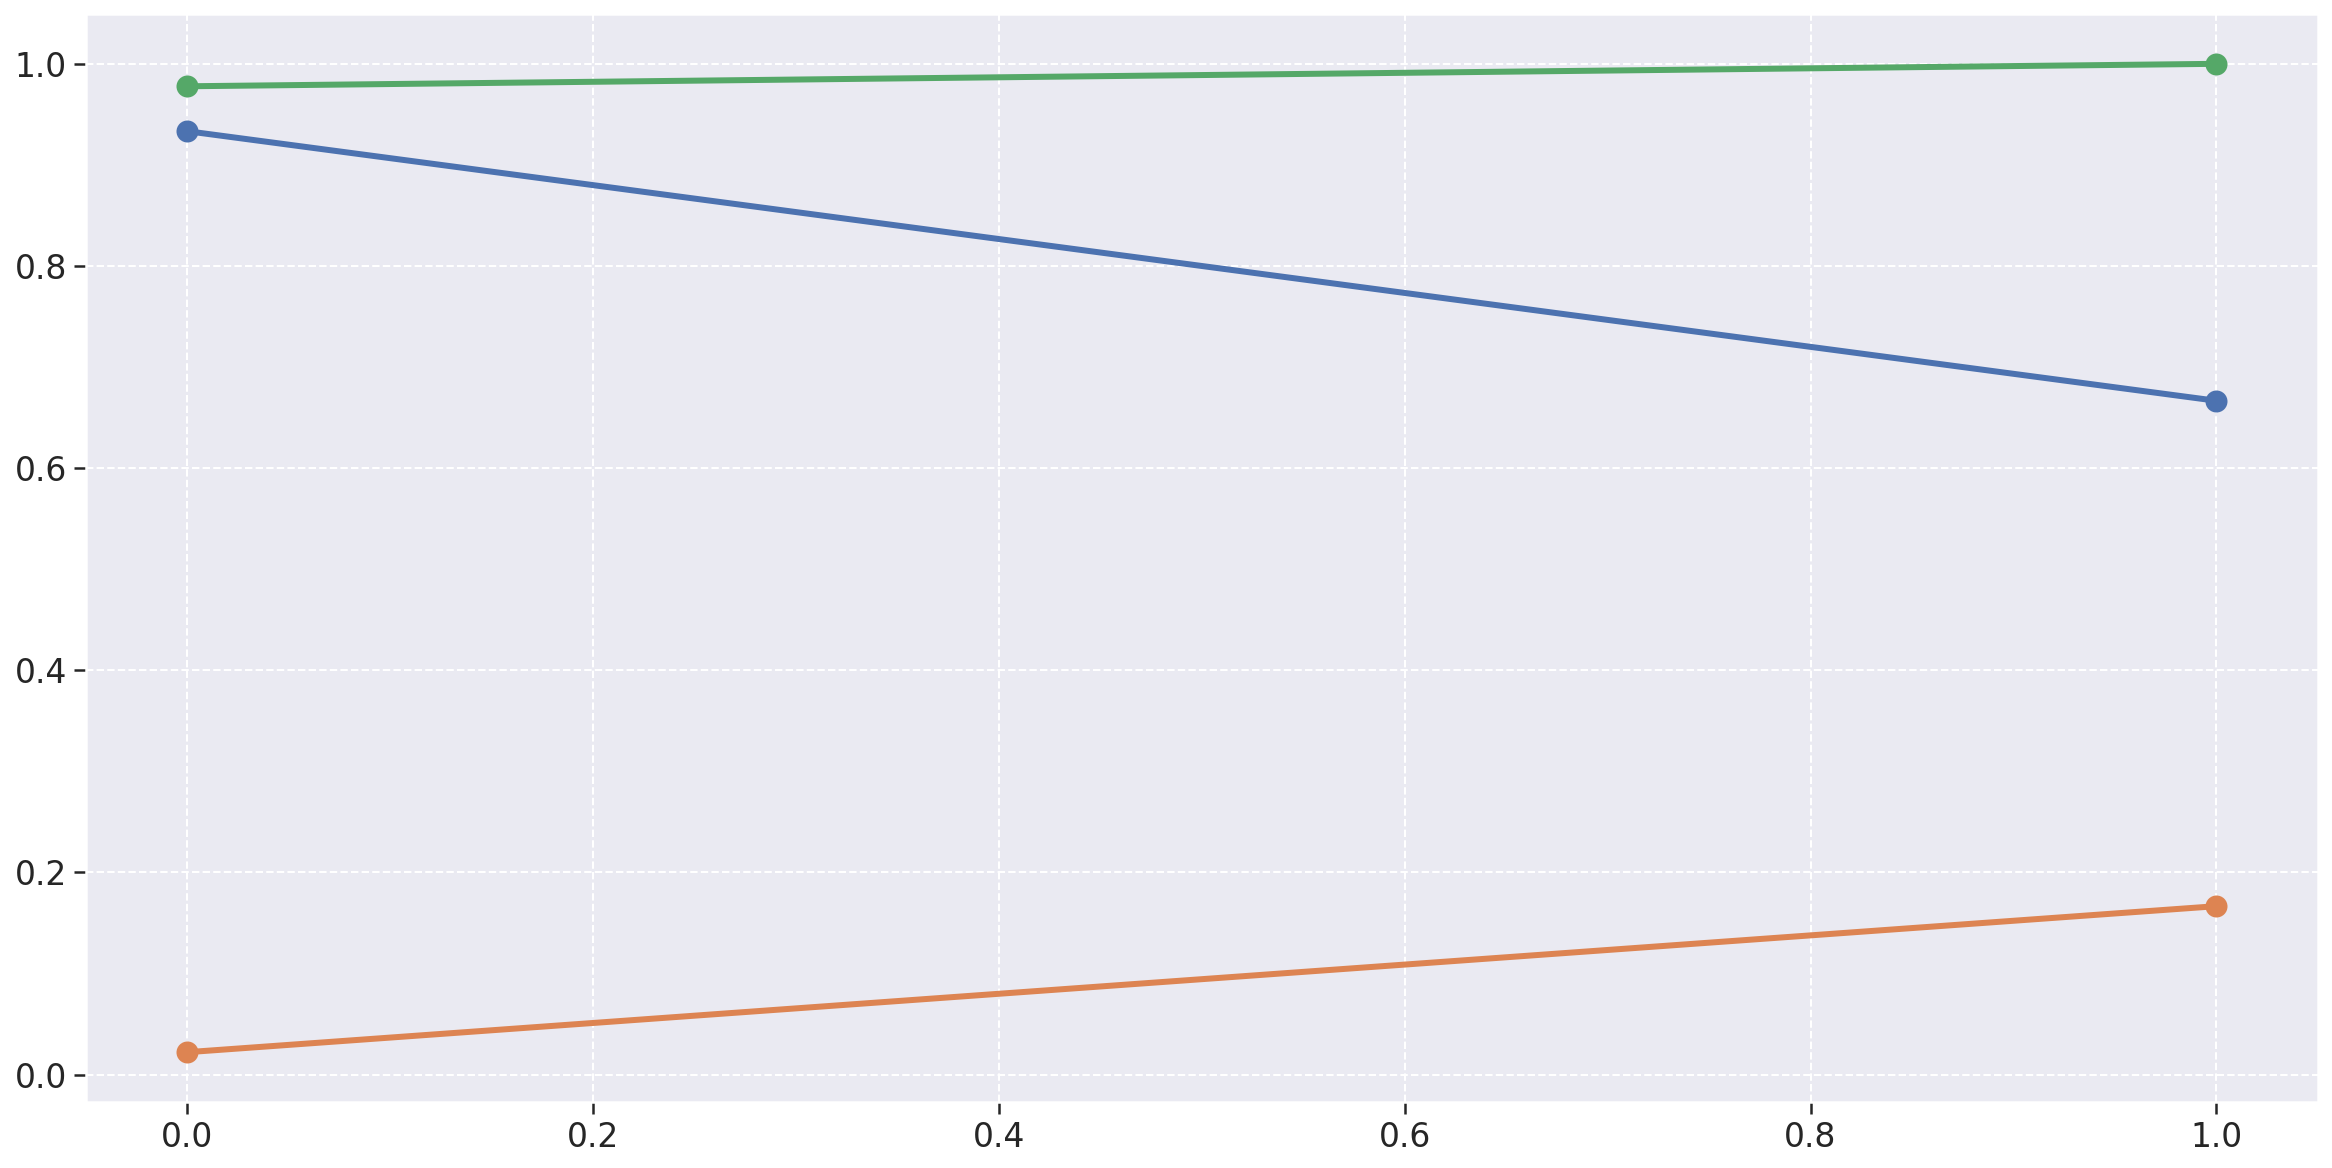

In [98]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(frontend_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(frontend_metrics['m3'], linewidth=3, marker='o', markersize=10)

### Sub characteristic aggregation

- You must do this for each of your repositories

In [100]:
psc1 = 1
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33

archives_metrics['asc1'] = ((archives_metrics['m1']*pm1)+(archives_metrics['m2']*pm2)+(archives_metrics['m3']*pm3))*psc1
profile_metrics['asc1'] = ((profile_metrics['m1']*pm1)+(profile_metrics['m2']*pm2)+(profile_metrics['m3']*pm3))*psc1
frontend_metrics['asc1'] = ((frontend_metrics['m1']*pm1)+(frontend_metrics['m2']*pm2)+(frontend_metrics['m3']*pm3))*psc1

## Archives

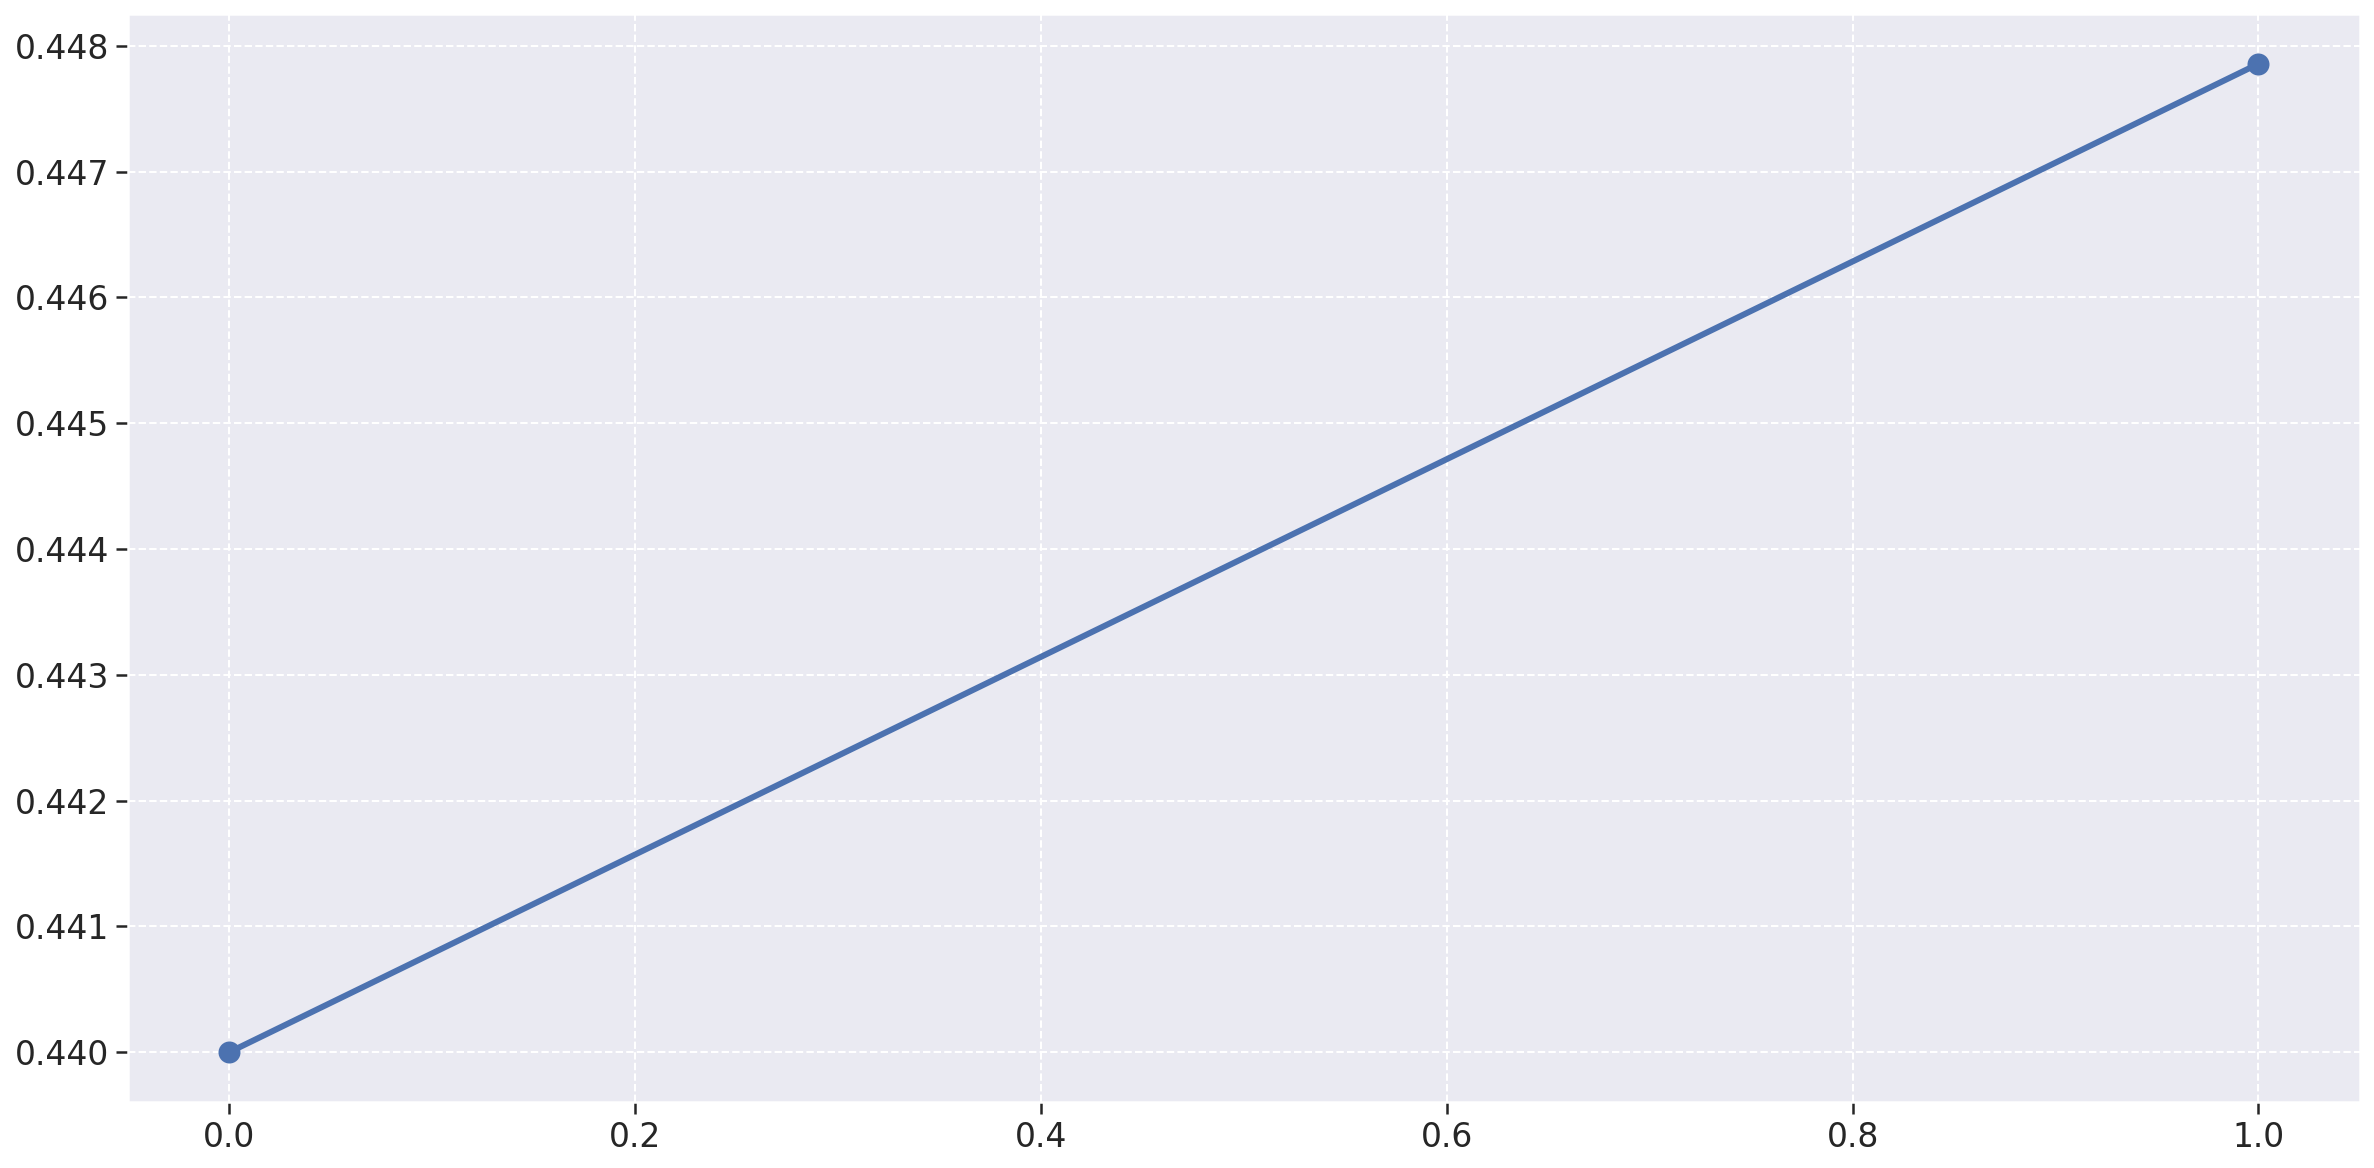

In [101]:
fig = plt.figure(figsize=(20, 10))

plt.plot(archives_metrics['asc1'], linewidth=3, marker='o', markersize=10)

## Profile

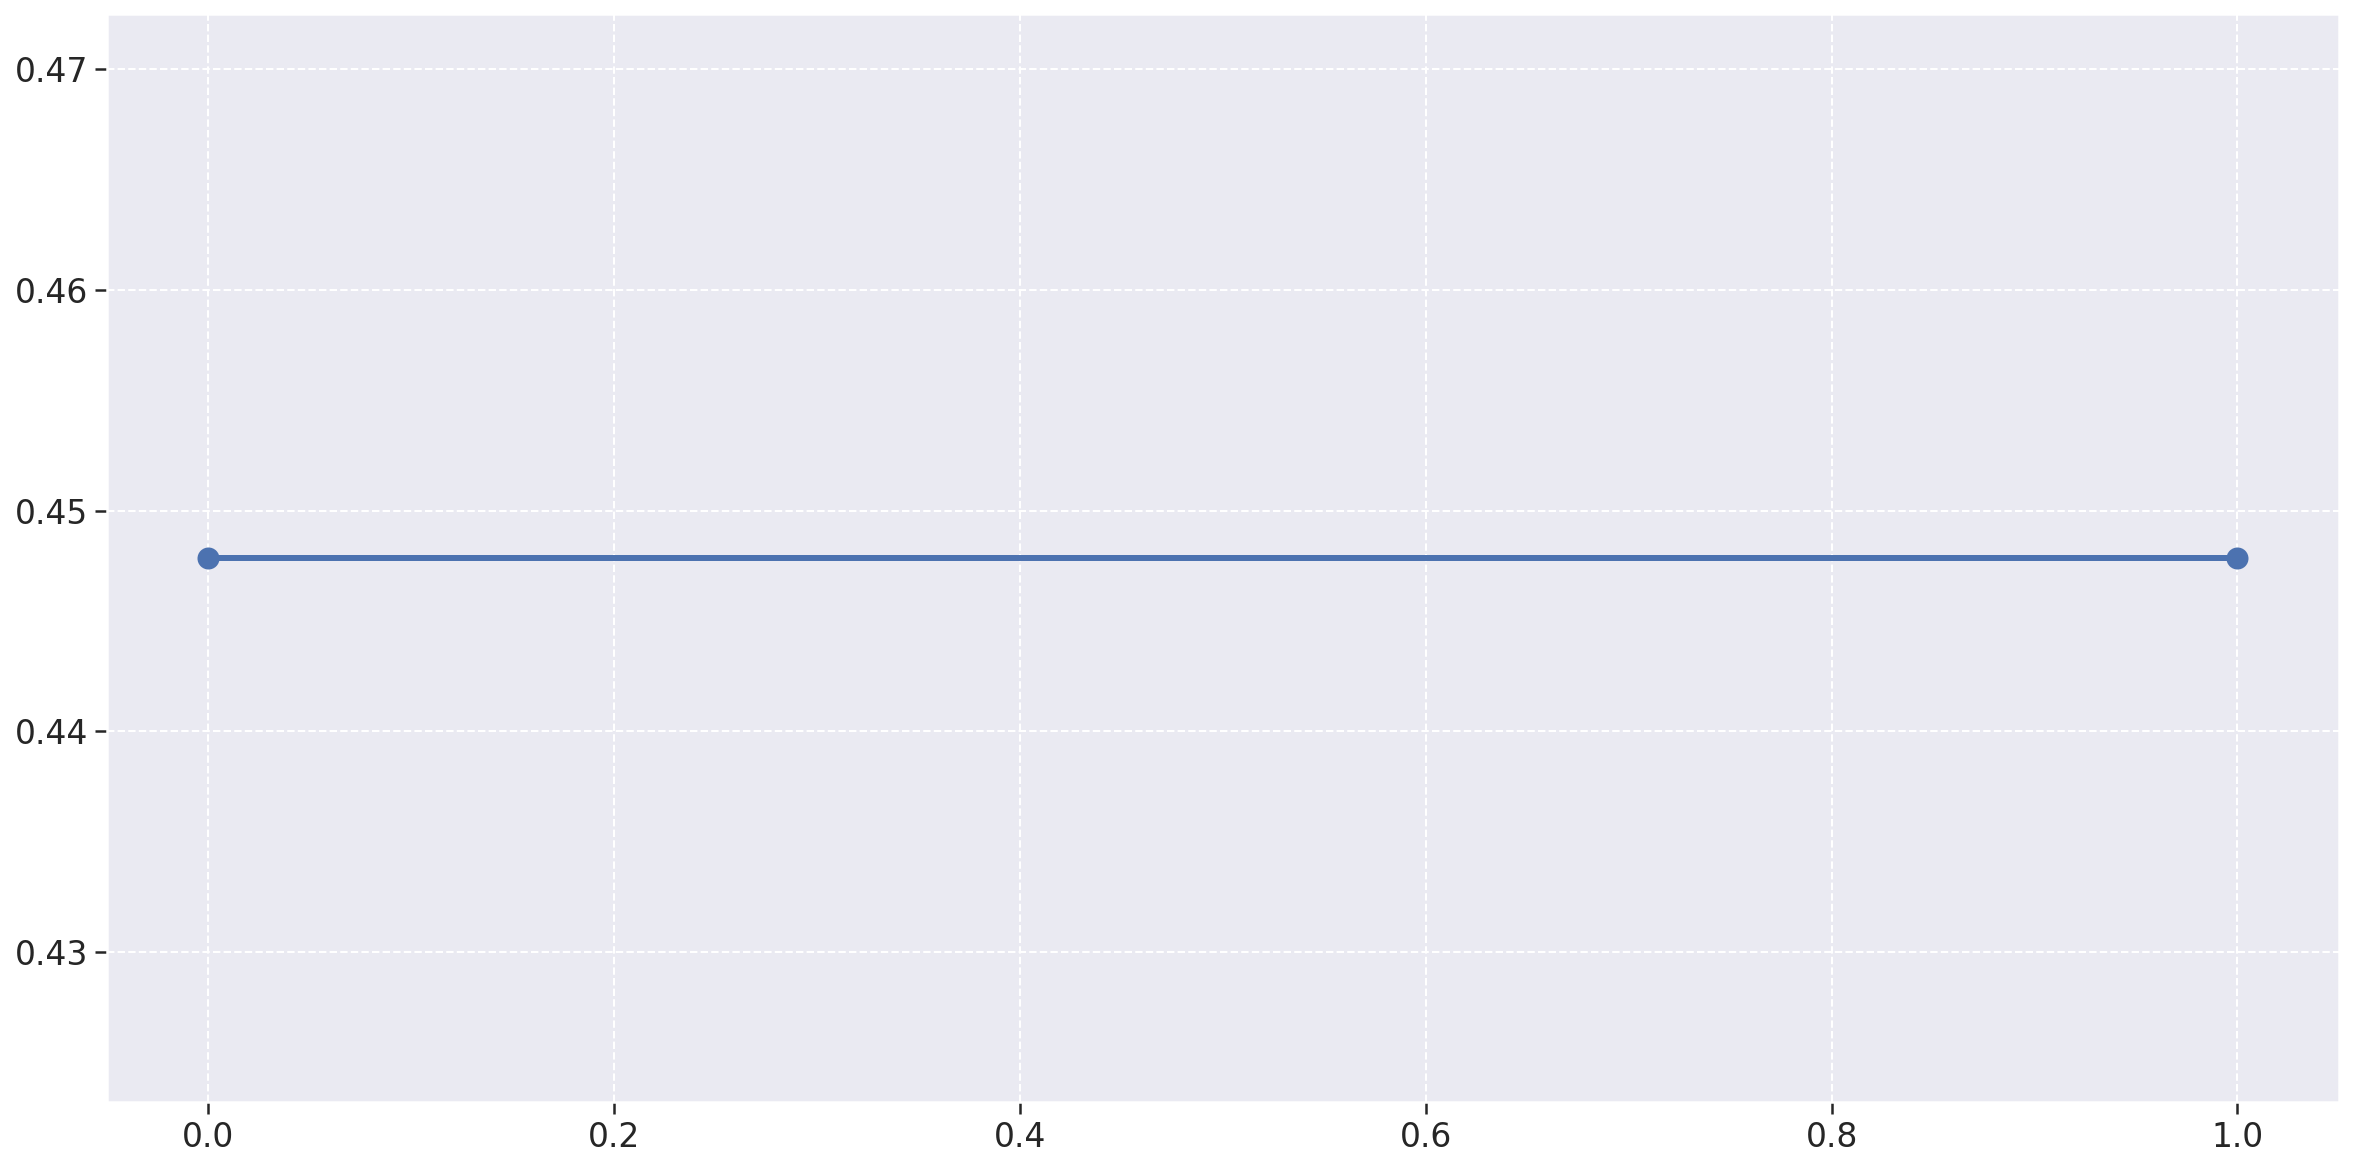

In [102]:
fig = plt.figure(figsize=(20, 10))

plt.plot(profile_metrics['asc1'], linewidth=3, marker='o', markersize=10)

## Frontend

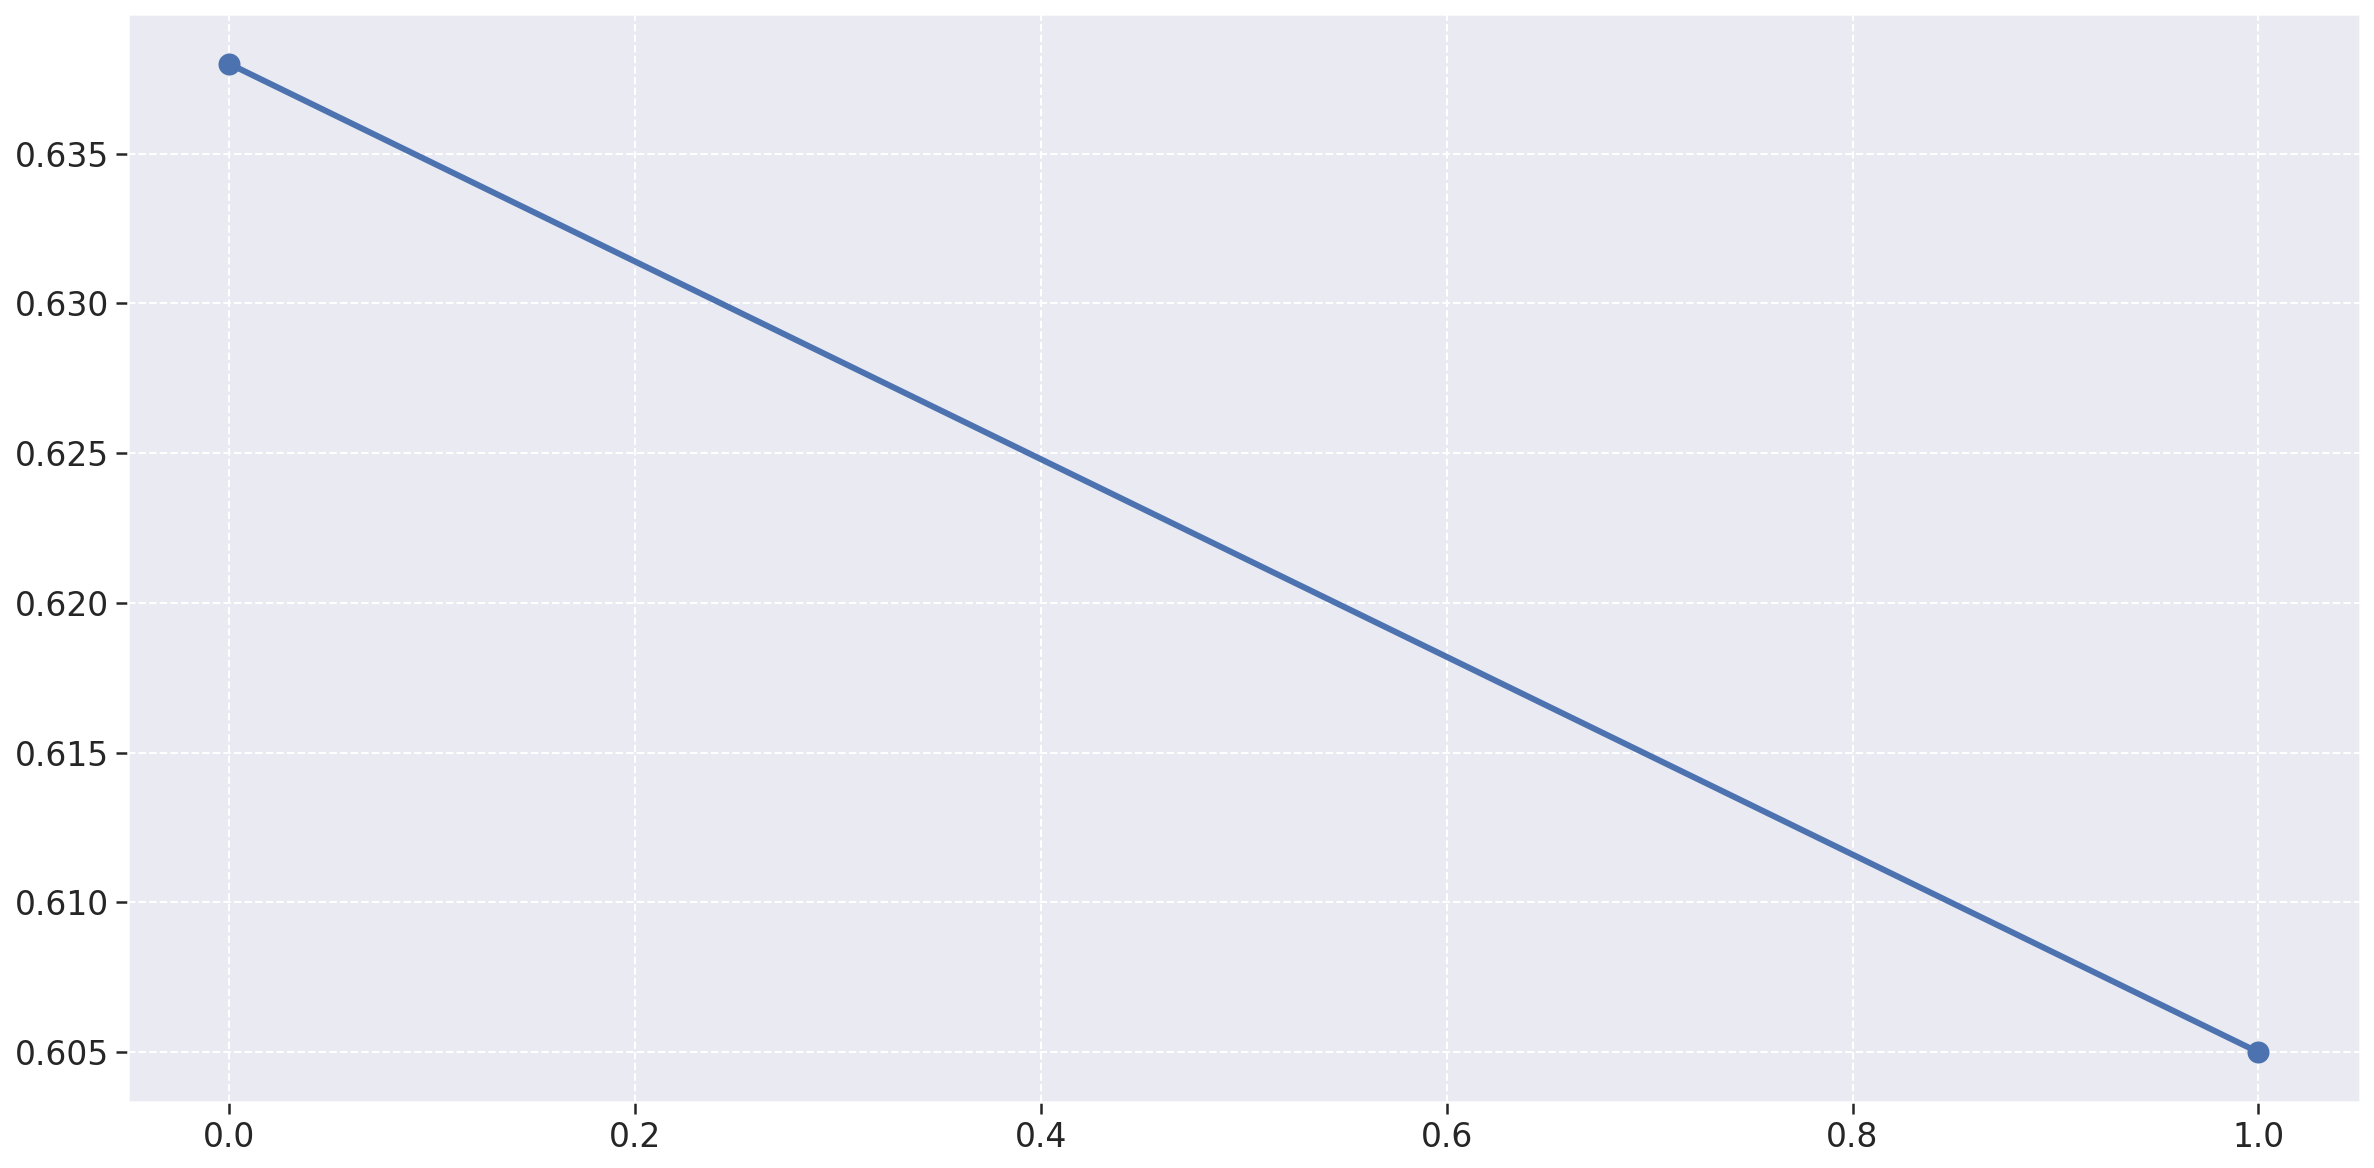

In [116]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['asc1'], linewidth=3, marker='o', markersize=10)

## All repositories

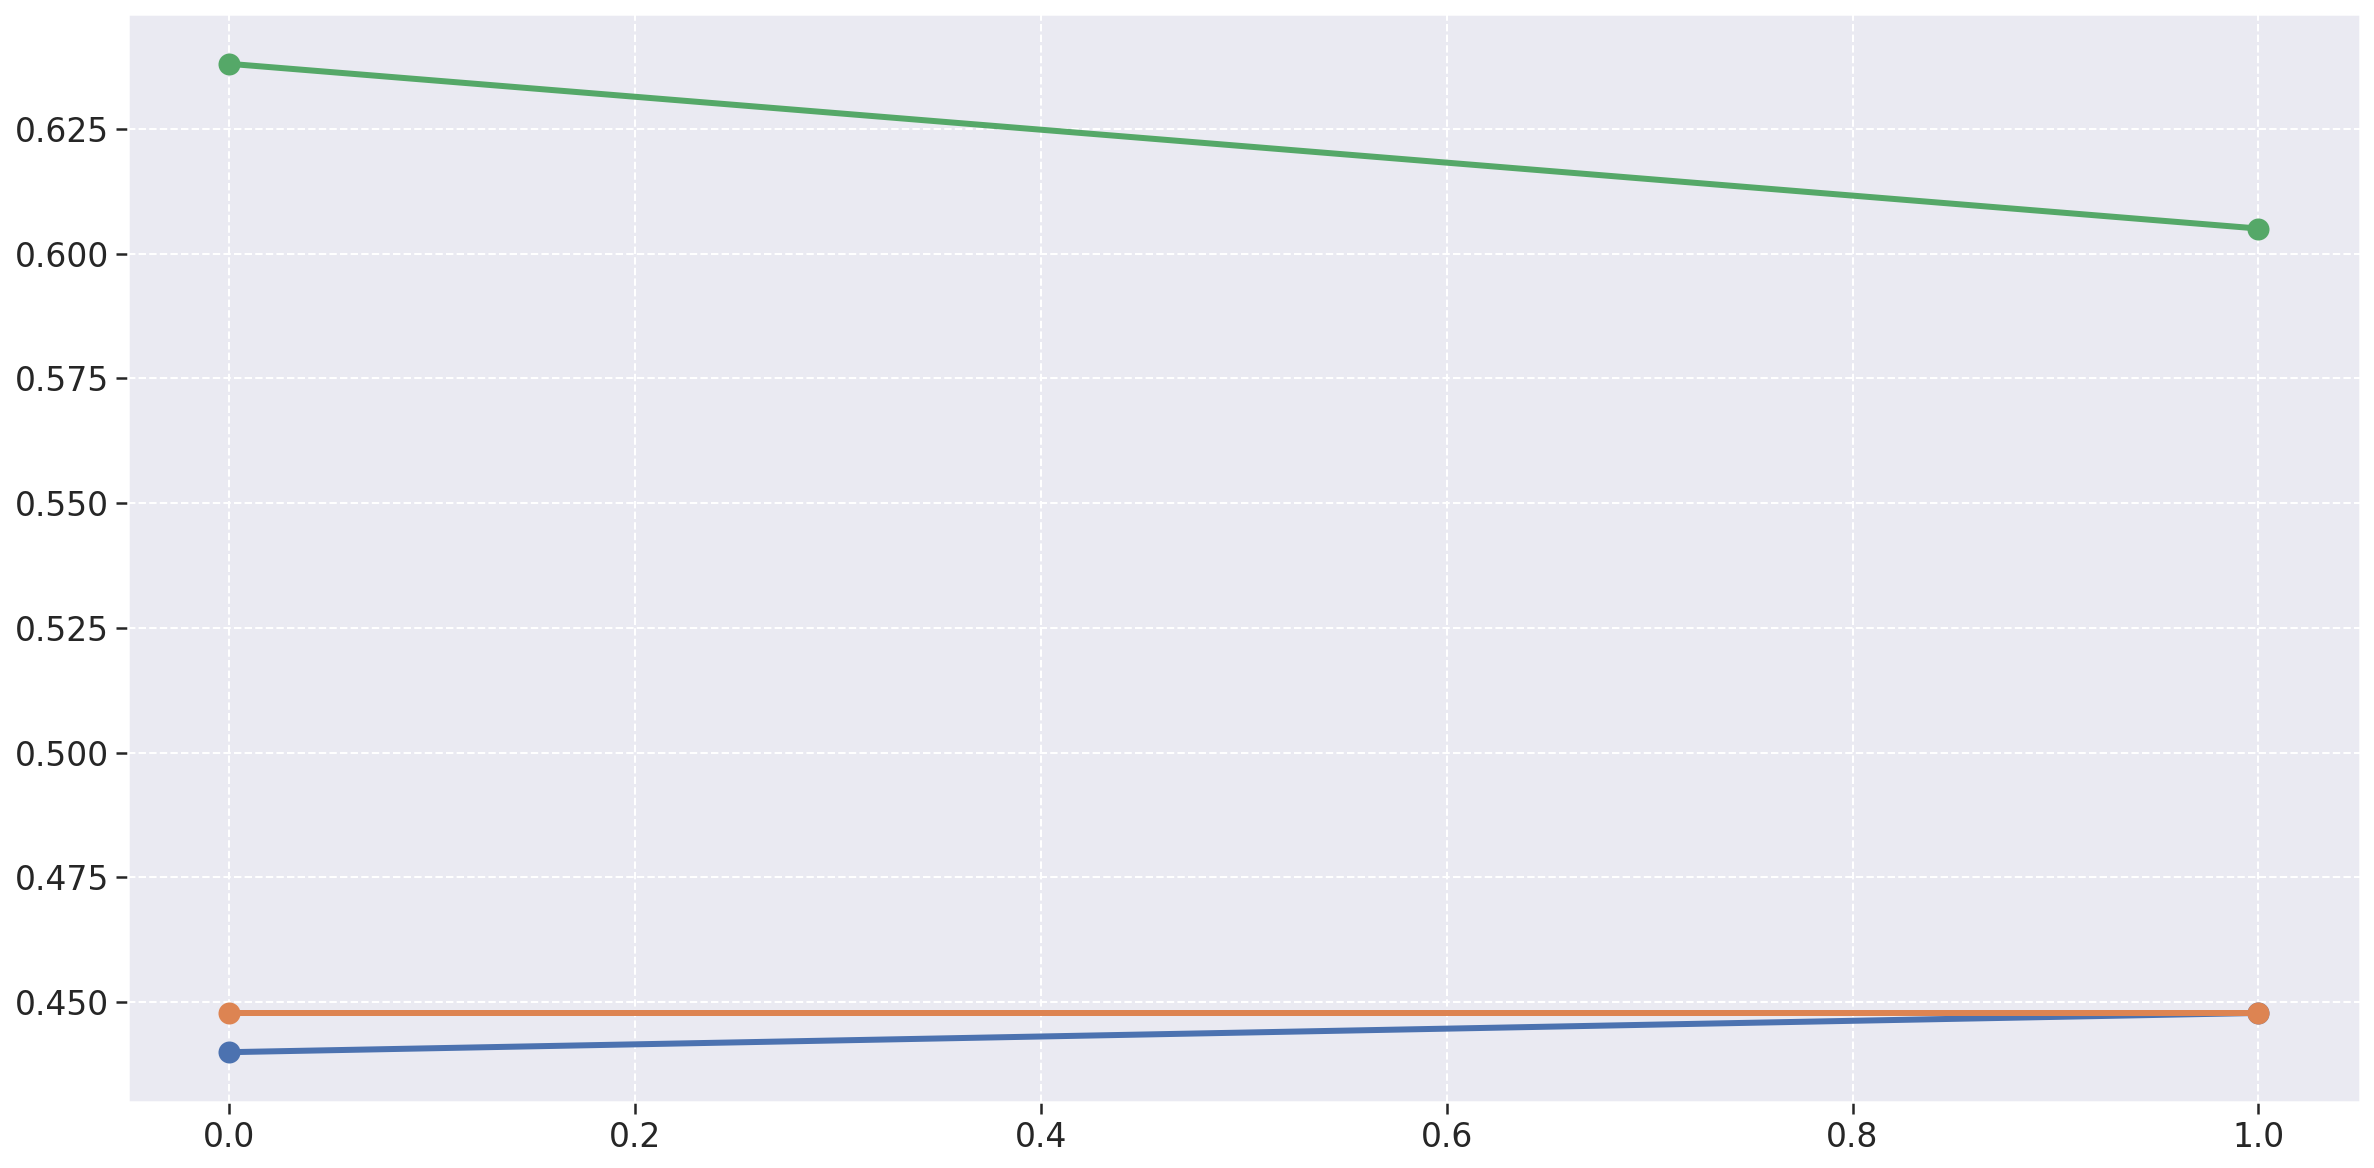

In [117]:
fig = plt.figure(figsize=(20, 10))


plt.plot(archives_metrics['asc1'], linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['asc1'], linewidth=3, marker='o', markersize=10)
plt.plot(frontend_metrics['asc1'], linewidth=3, marker='o', markersize=10)

In [121]:
metrics_df = pd.concat([archives_metrics, profile_metrics, frontend_metrics], ignore_index=True)

metrics_df['ac1'] = metrics_df['asc1'] * 1
metrics_df['total'] = metrics_df['asc1'] * 1

In [122]:
metrics_df

,m1,m2,m3,repository,version,asc1,ac1,total
0,0.133333,0.200000,1.000000,Archives,03-10-2021-15-47,0.440000,0.440000,0.220000
1,0.142857,0.214286,1.000000,Archives,13-09-2021-15-00,0.447857,0.447857,0.223929
2,0.142857,0.214286,1.000000,Profile,03-10-2021-15-48,0.447857,0.447857,0.223929
3,0.142857,0.214286,1.000000,Profile,13-09-2021-14-00,0.447857,0.447857,0.223929
4,0.933333,0.022222,0.977778,Frontend,03-10-2021-15-49,0.638000,0.638000,0.319000
5,0.666667,0.166667,1.000000,Frontend,13-09-2021-20-00,0.605000,0.605000,0.302500


# Metrics to file

In [119]:
metrics_df.to_excel('data/excel_data/metrics_df.xlsx', index = False)

In [120]:
now = datetime.now()
now_str = now.strftime("%d-%m-%Y-%H-%M")

metrics_df.to_csv('./data/csv_data/fga-eps-mds-2021-1-PC-GO1-qualidade-total-produto-{}.csv'.format(now_str), index = False)